In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### A. Summarize the data. How much data is present? What attributes/features are continuous valued? Which attributes are categorical? [5 points] 

Data Summary:
- The dataset contains 1,949 rows and 11 columns.
- Categorical Attribute: Country name
- Continuous Attributes: Log GDP per capita, Social support, Freedom to make life choices, Generosity, Perceptions of corruption, Positive affect, Negative affect, Healthy life expectancy at birth (Target variable)
- Observations: Some attributes have missing values (e.g., "Log GDP per capita" has 1913 non-null values, "Healthy life expectancy at birth" has 1894 non-null values, etc.).

In [2]:
df = pd.read_csv('happiness_data.csv')

In [3]:
# Get an overview of the dataset
summary = df.describe(include='all')  # Includes both numerical and categorical statistics
num_rows, num_cols = df.shape  # Get the number of rows and columns

# Identify continuous (numerical) and categorical attributes
continuous_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

# Print summary information
print(f"Total data points: {num_rows} rows, {num_cols} columns\n")
print(f"Continuous attributes: {continuous_features}\n")
print(f"Categorical attributes: {categorical_features}\n")


Total data points: 1949 rows, 11 columns

Continuous attributes: ['year', 'Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']

Categorical attributes: ['Country name']



In [4]:
print('The number of non-null values for the "Log of GDP per capita":',df['Log GDP per capita'].count())
print('The number of non-null values for the "Healthy life expectancy at birth":',df['Healthy life expectancy at birth'].count())

The number of non-null values for the "Log of GDP per capita": 1913
The number of non-null values for the "Healthy life expectancy at birth": 1894


### B. Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Explain noticeable traits for key attributes. Are there any attributes that might require special treatment? If so, what special treatment might they require? [5 points]

**Notable Traits for Key Attributes**:

- Log GDP per Capita: The values range from around 6 to 12, suggesting significant economic disparity among countries. The distribution appears to be normally distributed but with a slight right-skew, meaning some countries have extremely high GDP per capita.
- Healthy Life Expectancy at Birth: The values range from below 50 to over 70, with a clear left-skew, indicating that many countries have a higher life expectancy, while a few have significantly lower values.
- Generosity & Perceptions of Corruption: These attributes exhibit high variability and skewed distributions, with many values clustering towards the lower end. Generosity appears to have more extreme outliers, suggesting that some countries report exceptionally high values.
- Freedom to Make Life Choices & Social Support: Both distributions suggest that most countries report high social support and perceived freedom, but a few countries experience significantly lower values.

**Potential Special Treatments**:

Missing Values: Columns like Log GDP per capita, Healthy Life Expectancy, Generosity, and Perceptions of Corruption contain missing data, which could be:
- Interpolated if the missing data follows a trend.
- Dropped if missing values are minimal.
- Imputed with median or mean values.

Outliers: Certain attributes, such as Generosity and Perceptions of Corruption, might require outlier treatment (e.g., winsorization or log transformation) to prevent skewed analysis.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


In [6]:
df.head()

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008        3.724               7.370           0.451   
1  Afghanistan  2009        4.402               7.540           0.552   
2  Afghanistan  2010        4.758               7.647           0.539   
3  Afghanistan  2011        3.832               7.620           0.521   
4  Afghanistan  2012        3.783               7.705           0.521   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                             50.80                         0.718       0.168   
1                             51.20                         0.679       0.190   
2                             51.60                         0.600       0.121   
3                             51.92                         0.496       0.162   
4                             52.24                         0.531       0.236   

   Perceptions of corruption  Positive affect  Negative affect  
0                      0.882            0.518            0.258  
1                      0.850            0.584            0.237  
2                      0.707            0.618            0.275  
3                      0.731            0.611            0.267  
4                      0.776            0.710            0.268

In [7]:
df.describe()

year  Life Ladder  Log GDP per capita  Social support  \
count  1949.000000  1949.000000         1913.000000     1936.000000   
mean   2013.216008     5.466705            9.368453        0.812552   
std       4.166828     1.115711            1.154084        0.118482   
min    2005.000000     2.375000            6.635000        0.290000   
25%    2010.000000     4.640000            8.464000        0.749750   
50%    2013.000000     5.386000            9.460000        0.835500   
75%    2017.000000     6.283000           10.353000        0.905000   
max    2020.000000     8.019000           11.648000        0.987000   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       1894.000000                   1917.000000   
mean                          63.359374                      0.742558   
std                            7.510245                      0.142093   
min                           32.300000                      0.258000   
25%                           58.685000                      0.647000   
50%                           65.200000                      0.763000   
75%                           68.590000                      0.856000   
max                           77.100000                      0.985000   

        Generosity  Perceptions of corruption  Positive affect  \
count  1860.000000                1839.000000      1927.000000   
mean      0.000103                   0.747125         0.710003   
std       0.162215                   0.186789         0.107100   
min      -0.335000                   0.035000         0.322000   
25%      -0.113000                   0.690000         0.625500   
50%      -0.025500                   0.802000         0.722000   
75%       0.091000                   0.872000         0.799000   
max       0.698000                   0.983000         0.944000   

       Negative affect  
count      1933.000000  
mean          0.268544  
std           0.085168  
min           0.083000  
25%           0.206000  
50%           0.258000  
75%           0.320000  
max           0.705000

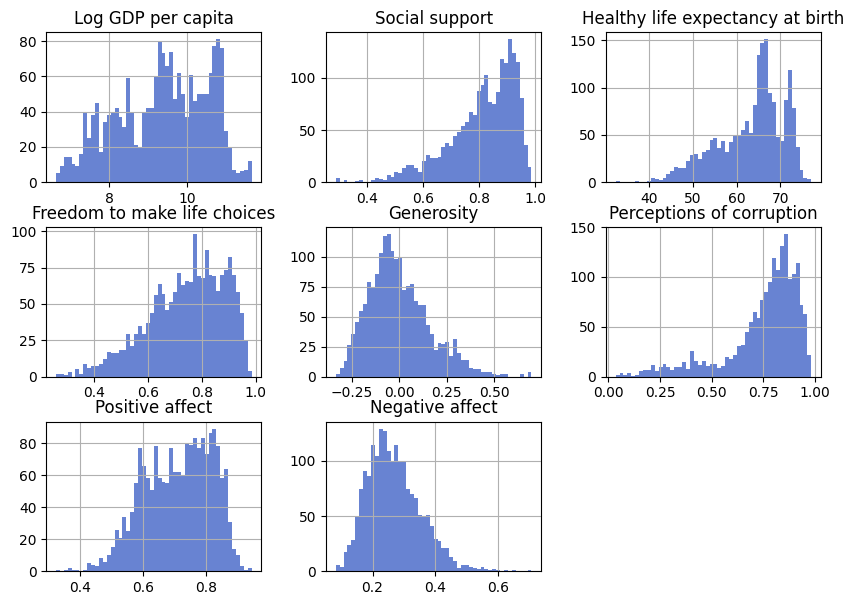

In [8]:
df_selected = df.drop(columns=["year", "Life Ladder"])
ax = df_selected.hist(bins=50, figsize=(10, 7), color='#6883d2', grid=True)

### C. Analyze the relationships between the data attributes, and between the data attributes and label. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots. [5 points]

**1. Pearson Correlation Heatmap Analysis**

**Since "Healthy life expectancy at birth" is the target variable (label), we focus on its relationships with other attributes:**

**Positive Correlations:**

- Log GDP per capita shows a strong positive correlation with Healthy life expectancy. This indicates that economically developed countries tend to have longer life expectancies, likely due to better healthcare, improved living conditions, and access to medical resources.
- Social support is also positively correlated with Healthy life expectancy, suggesting that in societies with strong support networks, people have better access to healthcare, mental well-being, and overall health resources.
- Freedom to make life choices exhibits a positive correlation, implying that societies with greater personal freedom may provide better healthcare accessibility and lifestyle choices that contribute to longer life expectancy.

**Negative Correlations:**

- Perceptions of corruption has a negative correlation with Healthy life expectancy, indicating that in countries where corruption is perceived to be high, public healthcare systems may be inefficient or resources may be unequally distributed, leading to lower life expectancy.
- Negative affect may also have a slight negative impact on life expectancy, as chronic stress, anxiety, and other negative emotions can have adverse effects on health.

**Weak or No Significant Correlations:**

- Generosity does not show a strong correlation with Healthy life expectancy, implying that charitable behavior at a national level does not directly impact average life expectancy.


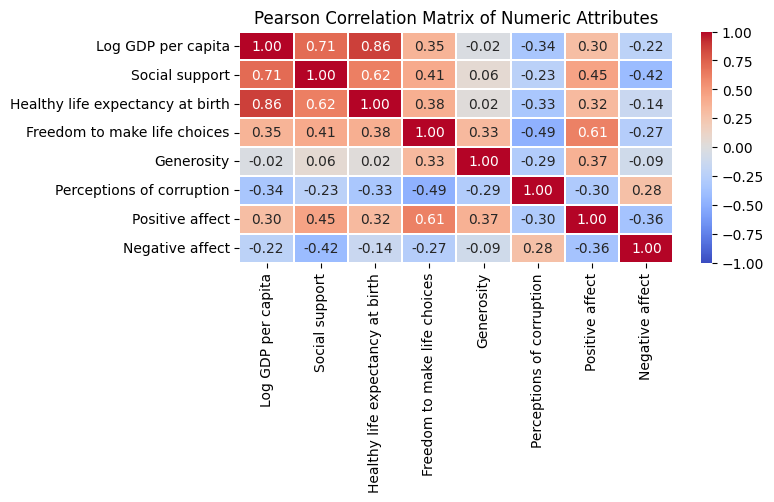

In [9]:
df_selected2 = df_selected.dropna()
numeric_df = df_selected2.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')  # Compute Pearson Correlation Coefficient (PCC) 
plt.figure(figsize=(7, 3))  # Plot heatmap of correlation matrix 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1,vmin=-1,vmax=1)
plt.title("Pearson Correlation Matrix of Numeric Attributes")
plt.show()

**2. Scatter Plot Analysis**

**Healthy Life Expectancy vs. Log GDP per capita:**
A clear positive correlation is observed, meaning that higher economic levels are associated with longer life expectancy. However, the difference in life expectancy among high-income countries is relatively small.

**Healthy Life Expectancy vs. Social Support:**
A positive correlation indicates that countries with strong social support systems tend to have higher life expectancy.

**Healthy Life Expectancy vs. Freedom to Make Life Choices:**
A positive trend suggests that countries with more personal freedoms may provide better access to healthcare and lifestyle choices.

**Healthy Life Expectancy vs. Perceptions of Corruption:**
A negative trend suggests that countries with higher perceived corruption often have lower life expectancy, possibly due to ineffective public health policies.

**Healthy Life Expectancy vs. Generosity:**
No clear pattern is observed, indicating that a country's level of generosity does not significantly impact life expectancy.


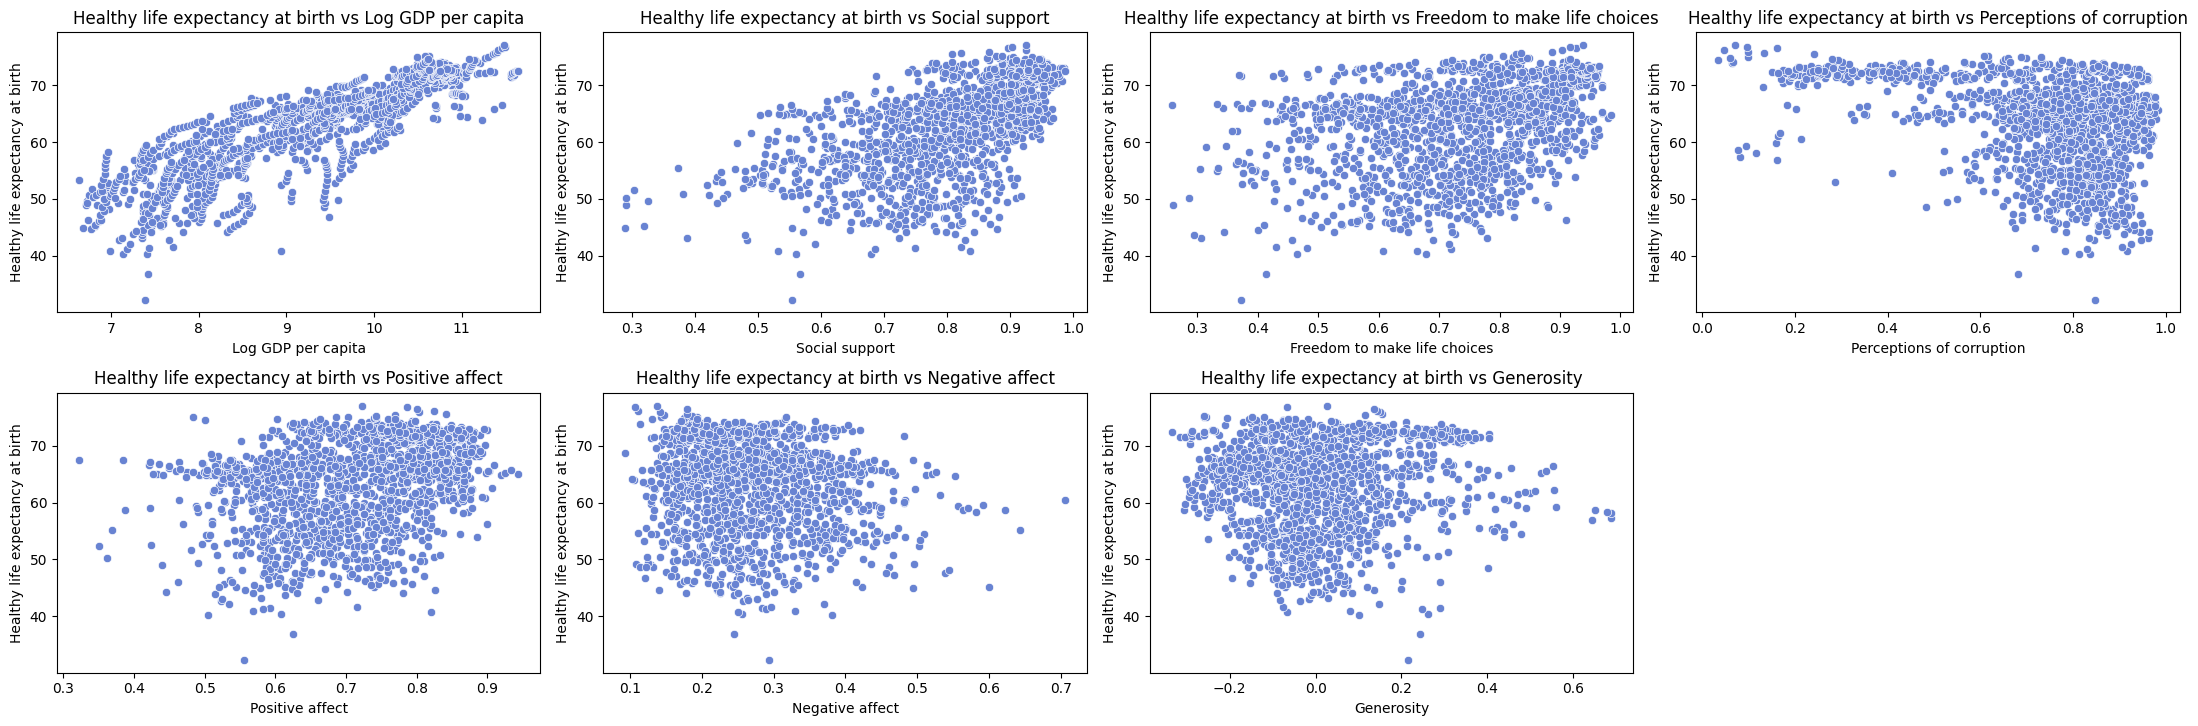

In [10]:
# Identify highly correlated attributes with Healthy life expectancy at birth
high_corr_features = correlation_matrix["Healthy life expectancy at birth"].abs().sort_values(ascending=False)[1:].index

# Generate scatter plots
fig, axes = plt.subplots(2, 4, figsize=(22, 8))

for i, feature in enumerate(high_corr_features):
    ax = axes[i // 4, i % 4]
    sns.scatterplot(x=numeric_df[feature], y=numeric_df["Healthy life expectancy at birth"], ax=ax, c = '#6883d2')
    ax.set_xlabel(feature)
    ax.set_ylabel("Healthy life expectancy at birth")
    ax.set_title(f"Healthy life expectancy at birth vs {feature}")
axes[1, 3].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### D. Select 20% of the data for testing. Describe how you did that and verify that your test portion of the data is representative of the entire dataset. [5 points]

**1. Preprocessing:**

- Removed the "year" and "Life Ladder" columns, got df_selected.
- Dropped any missing values to ensure the dataset is complete, got df_selected2.

**2.Splitting the Data:**

- Used train_test_split(df_selected2, test_size=0.2, random_state=42), which:
- Allocates 80% of the data for training.
- Allocates 20% of the data for testing.
- The random_state=42 ensures the results are reproducible.

**3. Verifying Representativeness:**

- Compared summary statistics (mean, standard deviation, min, max, etc.) for the training and testing sets.
- If the statistics are similar, the test set represents the entire dataset well.

**Use three methods to verify whether the test set is representative:**

- Histogram & Kernel Density Estimation: If the two curves overlap well, the test set is likely representative.
- Compare summary statistics: Check the mean, standard deviation, median, minimum, and maximum values between the test set and the full dataset. If the values are similar, the test set is representative.
- Kolmogorov-Smirnov Test: Determine whether the distributions of the test set and the full dataset are significantly different. **p-value > 0.05** → No significant difference (the test set is representative).

In [11]:
df_train, df_test = train_test_split(df_selected2, test_size=0.2, random_state=42)

Histogram & Kernel Density Estimation: If the two curves overlap well, the test set is likely representative.

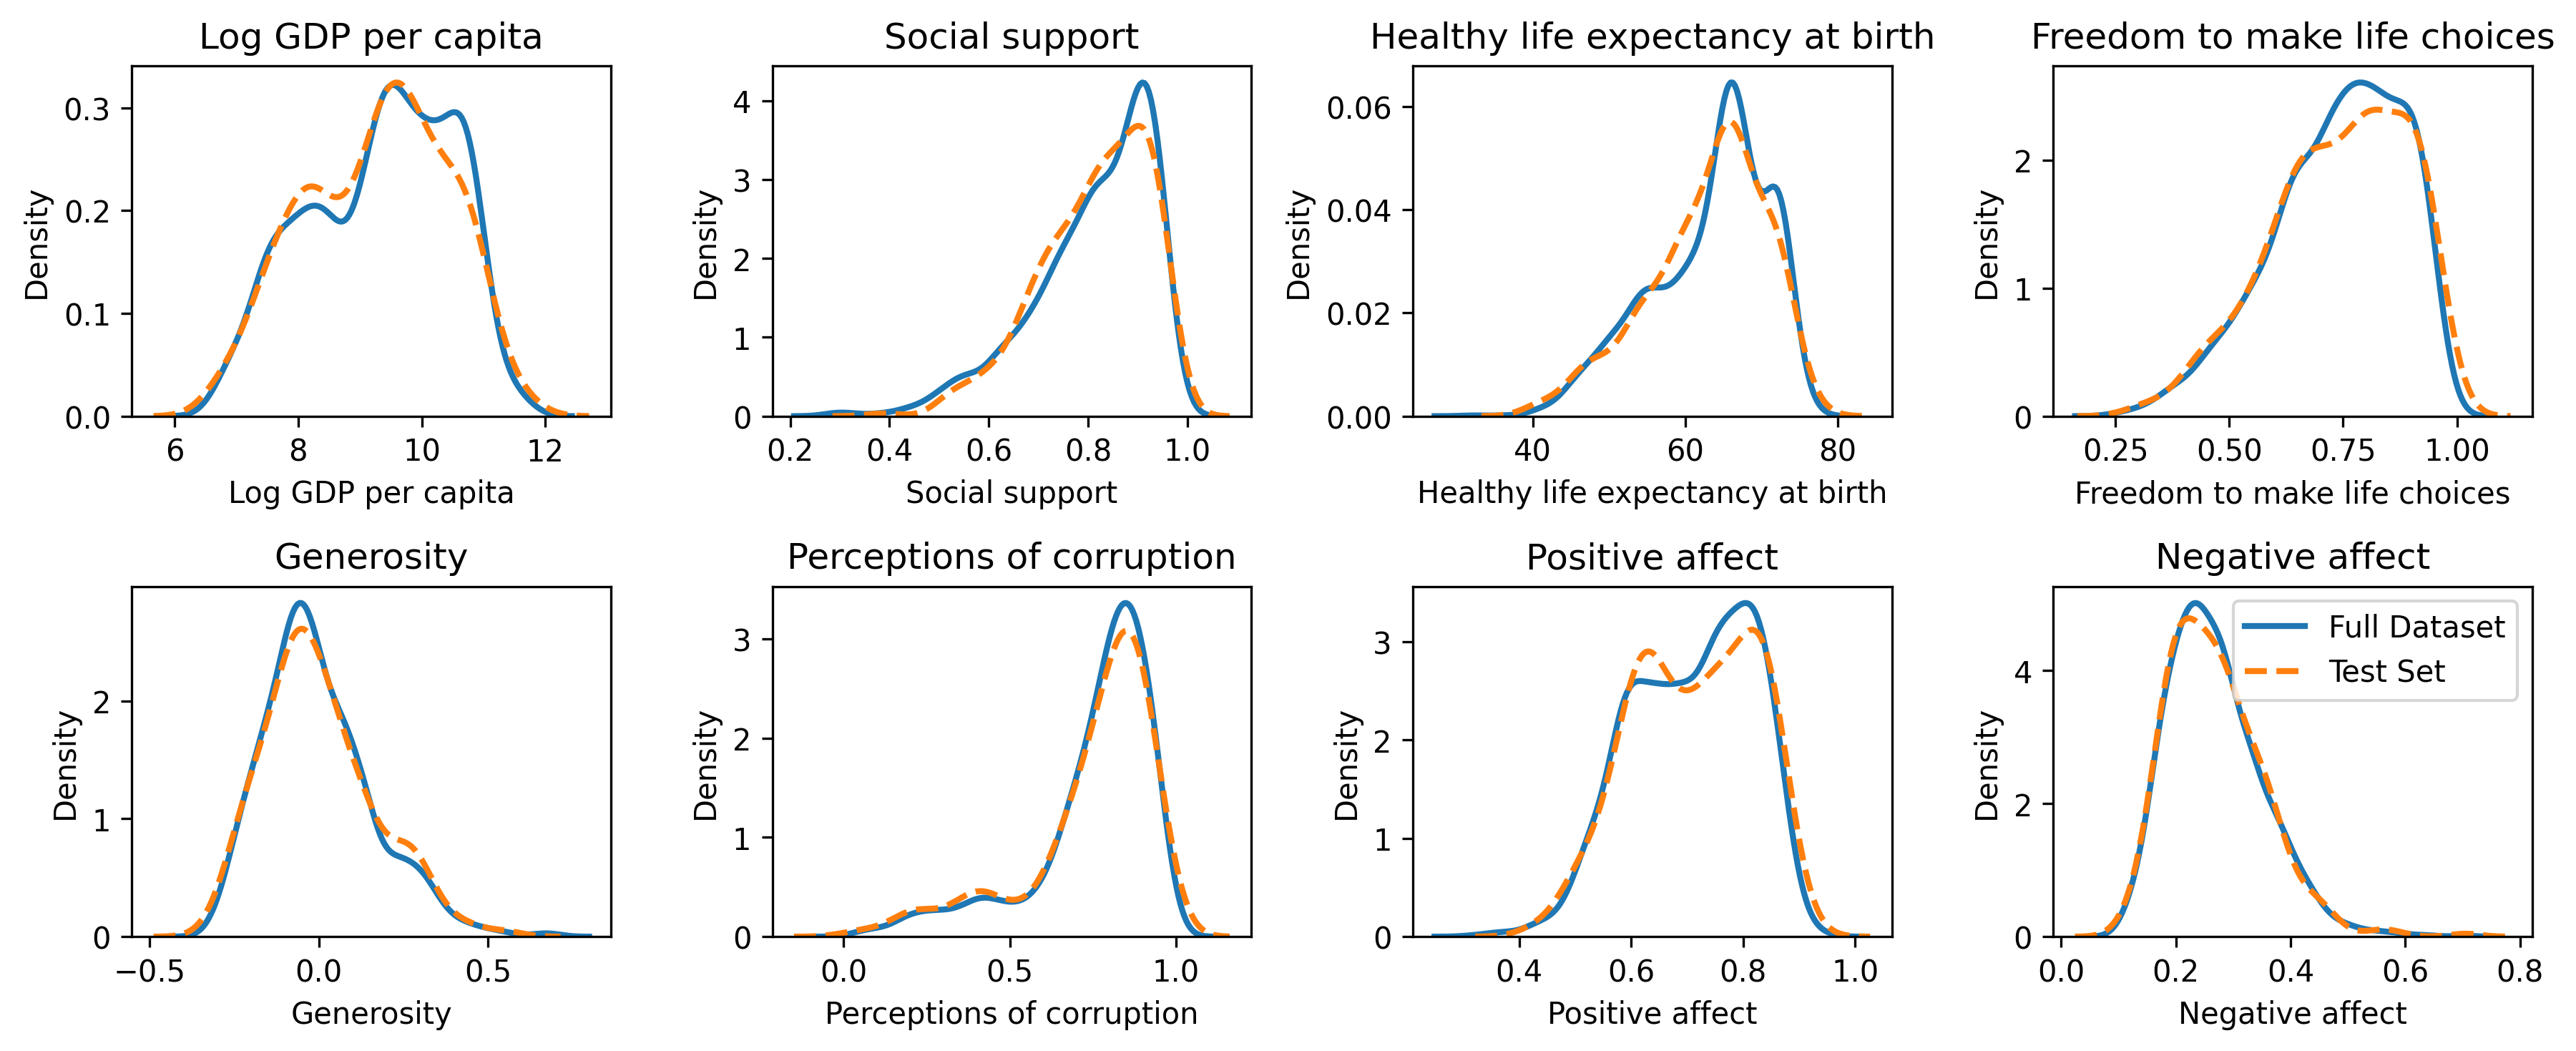

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = df_selected2.select_dtypes(include="number").columns

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), dpi=300)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical column as a KDE plot
for i, col in enumerate(numeric_cols[:9]):  # Ensure we don't exceed 8 plots
    sns.kdeplot(df_selected2[col], label="Full Dataset", linewidth=2, ax=axes[i])
    sns.kdeplot(df_test[col], label="Test Set", linestyle="dashed", linewidth=2, ax=axes[i])
    axes[i].set_title(f"{col}")
axes[7].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Compare summary statistics

In [13]:
df_selected2.describe() 

Log GDP per capita  Social support  Healthy life expectancy at birth  \
count         1708.000000     1708.000000                       1708.000000   
mean             9.321709        0.810321                         63.225465   
std              1.158344        0.121638                          7.687011   
min              6.635000        0.290000                         32.300000   
25%              8.394000        0.741000                         58.175000   
50%              9.456500        0.835000                         65.100000   
75%             10.272000        0.908000                         68.685000   
max             11.648000        0.987000                         77.100000   

       Freedom to make life choices   Generosity  Perceptions of corruption  \
count                   1708.000000  1708.000000                1708.000000   
mean                       0.739442    -0.000638                   0.750996   
std                        0.142846     0.162103                   0.186028   
min                        0.258000    -0.335000                   0.035000   
25%                        0.644000    -0.111250                   0.697000   
50%                        0.757500    -0.025500                   0.806000   
75%                        0.852000     0.089000                   0.875000   
max                        0.985000     0.689000                   0.983000   

       Positive affect  Negative affect  
count       1708.00000      1708.000000  
mean           0.70955         0.269446  
std            0.10819         0.083083  
min            0.32200         0.094000  
25%            0.62300         0.208000  
50%            0.72200         0.259000  
75%            0.80125         0.319250  
max            0.94400         0.705000

In [14]:
df_test.describe() 

Log GDP per capita  Social support  Healthy life expectancy at birth  \
count          342.000000      342.000000                        342.000000   
mean             9.261880        0.813427                         62.884713   
std              1.147947        0.109152                          7.628888   
min              6.728000        0.387000                         40.380000   
25%              8.274500        0.738250                         58.425000   
50%              9.408500        0.832000                         64.800000   
75%             10.145500        0.903750                         68.050000   
max             11.640000        0.983000                         77.100000   

       Freedom to make life choices  Generosity  Perceptions of corruption  \
count                     342.00000  342.000000                 342.000000   
mean                        0.74183    0.001927                   0.742681   
std                         0.14754    0.164193                   0.197005   
min                         0.30400   -0.335000                   0.035000   
25%                         0.64225   -0.108500                   0.687250   
50%                         0.76150   -0.023500                   0.807000   
75%                         0.86300    0.101500                   0.876750   
max                         0.98000    0.561000                   0.977000   

       Positive affect  Negative affect  
count       342.000000       342.000000  
mean          0.711544         0.269246  
std           0.108982         0.084238  
min           0.423000         0.103000  
25%           0.626000         0.207250  
50%           0.715500         0.256500  
75%           0.809750         0.319250  
max           0.925000         0.705000

Kolmogorov-Smirnov Test

In [15]:
from scipy.stats import ks_2samp

for col in df_test.select_dtypes(include="number").columns:
    stat, p_value = ks_2samp(df_selected2[col].dropna(), df_test[col].dropna())
    print(f"{col}: KS Statistic = {stat:.4f}, p-value = {p_value:.4f}")

Log GDP per capita: KS Statistic = 0.0548, p-value = 0.3434
Social support: KS Statistic = 0.0370, p-value = 0.8152
Healthy life expectancy at birth: KS Statistic = 0.0449, p-value = 0.5940
Freedom to make life choices: KS Statistic = 0.0466, p-value = 0.5468
Generosity: KS Statistic = 0.0267, p-value = 0.9835
Perceptions of corruption: KS Statistic = 0.0319, p-value = 0.9237
Positive affect: KS Statistic = 0.0349, p-value = 0.8634
Negative affect: KS Statistic = 0.0312, p-value = 0.9339


### E. Train a Linear Regression model using the training data with four-fold cross-validation and with appropriate evaluation metric. Do this with a closed-form solution (using the Normal Equation or SVD) and with SGD. For SGD Perform Ridge, Lasso and Elastic Net regularization – try three values of penalty term and describe its impact. Explore the impact of other hyperparameters, like batch size and learning rate (no need for grid search). Describe your findings. For SGD, display the training and validation loss as a function of training iteration. [10 points]

Based on the Pearson correlation matrix (question C), the attributes with the highest correlation with Healthy life expectancy at birth are:

- Log GDP per capita (Strong positive correlation)
- Social support (Strong positive correlation)
- Freedom to make life choices (Moderate positive correlation)
- Perceptions of corruption (Moderate negative correlation)

Since these attributes have the highest absolute correlation values with Healthy life expectancy at birth, I will use them as features for the regression model.

Now, I will proceed with training a Linear Regression model using:

- Closed-form solution (Normal Equation or SVD)
- SGD-based optimization with Ridge, Lasso, and Elastic Net regularization.

In [16]:
df_cleaned = df_selected.dropna()
df_cleaned = df_cleaned.reset_index(drop=True)

In [17]:
df_cleaned

Country name  Log GDP per capita  Social support  \
0     Afghanistan               7.370           0.451   
1     Afghanistan               7.540           0.552   
2     Afghanistan               7.647           0.539   
3     Afghanistan               7.620           0.521   
4     Afghanistan               7.705           0.521   
...           ...                 ...             ...   
1703     Zimbabwe               7.984           0.768   
1704     Zimbabwe               8.016           0.754   
1705     Zimbabwe               8.049           0.775   
1706     Zimbabwe               7.950           0.759   
1707     Zimbabwe               7.829           0.717   

      Healthy life expectancy at birth  Freedom to make life choices  \
0                                50.80                         0.718   
1                                51.20                         0.679   
2                                51.60                         0.600   
3                                51.92                         0.496   
4                                52.24                         0.531   
...                                ...                           ...   
1703                             54.40                         0.733   
1704                             55.00                         0.753   
1705                             55.60                         0.763   
1706                             56.20                         0.632   
1707                             56.80                         0.643   

      Generosity  Perceptions of corruption  Positive affect  Negative affect  
0          0.168                      0.882            0.518            0.258  
1          0.190                      0.850            0.584            0.237  
2          0.121                      0.707            0.618            0.275  
3          0.162                      0.731            0.611            0.267  
4          0.236                      0.776            0.710            0.268  
...          ...                        ...              ...              ...  
1703      -0.095                      0.724            0.738            0.209  
1704      -0.098                      0.751            0.806            0.224  
1705      -0.068                      0.844            0.710            0.212  
1706      -0.064                      0.831            0.716            0.235  
1707      -0.009                      0.789            0.703            0.346  

[1708 rows x 9 columns]

__Part 1 Regression: Linear Model using K-Fold with Normal form and SGD (train and val loss)__

__Result Interpretation__
- __Lower RMSE for the Normal Equation (3.89):__
This method directly computes the optimal solution (Normal form) is not affected by hyperparameters like learning rate or iterations. It generally performs better for smaller datasets.

- __Slightly Higher RMSE for SGD (3.99):__
SGD approximates the optimal solution through iterative updates. Its performance can be influenced by hyperparameters (e.g., learning rate, number of iterations), leading to a slightly less precise result than the Normal Equation.

- __Minimal RMSE Difference (~0.1):__
This suggests that linear regression is suitable for this dataset. While the Normal Equation provides an exact solution, SGD remains a viable alternative for large datasets where matrix inversion is computationally expensive.

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Select features and target variable
selected_features = ["Log GDP per capita", "Social support", "Freedom to make life choices", "Perceptions of corruption"]
target_variable = "Healthy life expectancy at birth"

X = df_cleaned[selected_features].values
y = df_cleaned[target_variable].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (necessary for SGD)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up K-Fold Cross-validation (4 folds)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

### Normal Equation Method ###
rmse_train_list = []
rmse_val_list = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Add bias term (intercept) to feature matrices
    X_train_bias = np.c_[np.ones((X_train_fold.shape[0], 1)), X_train_fold]
    X_val_bias = np.c_[np.ones((X_val_fold.shape[0], 1)), X_val_fold]

    # Compute theta using Normal Equation: theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train_fold

    # Predict on training and validation sets
    y_train_pred = X_train_bias @ theta
    y_val_pred = X_val_bias @ theta

    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

    print(f"Normal Eq - Fold RMSE: Training = {rmse_train:.4f}, Validation = {rmse_val:.4f}")

# Print overall RMSE for Normal Equation
print(f"\nNormal Eq - Average Training RMSE: {np.mean(rmse_train_list):.4f}")
print(f"Normal Eq - Average Validation RMSE: {np.mean(rmse_val_list):.4f}")
print(" ")
### Stochastic Gradient Descent (SGD) Method ###
rmse_train_list = []
rmse_val_list = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Initialize a new SGD model for each fold to prevent accumulating weights
    sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.01, random_state=42)
    sgd_reg.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = sgd_reg.predict(X_train_fold)
    y_val_pred = sgd_reg.predict(X_val_fold)

    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

    print(f"SGD - Fold RMSE: Training = {rmse_train:.4f}, Validation = {rmse_val:.4f}")

# Print overall RMSE for SGD
print(f"\nSGD - Average Training RMSE: {np.mean(rmse_train_list):.4f}")
print(f"SGD - Average Validation RMSE: {np.mean(rmse_val_list):.4f}")


Normal Eq - Fold RMSE: Training = 3.8603, Validation = 3.9196
Normal Eq - Fold RMSE: Training = 3.8994, Validation = 3.8047
Normal Eq - Fold RMSE: Training = 3.8388, Validation = 3.9810
Normal Eq - Fold RMSE: Training = 3.8814, Validation = 3.8572

Normal Eq - Average Training RMSE: 3.8700
Normal Eq - Average Validation RMSE: 3.8906
 
SGD - Fold RMSE: Training = 3.8677, Validation = 3.9283
SGD - Fold RMSE: Training = 3.9561, Validation = 3.9208
SGD - Fold RMSE: Training = 3.9053, Validation = 3.9900
SGD - Fold RMSE: Training = 4.1224, Validation = 4.1223

SGD - Average Training RMSE: 3.9629
SGD - Average Validation RMSE: 3.9903


__Part 2 Regularization: Regularization with different penalty terms__

**1. Effect of alpha on Convergence**

**Small Regularization (alpha = 0.01):**

- The training and validation loss decrease quickly, and the final RMSE stabilizes around 3.8 - 4.2.
- Training and validation curves remain closely aligned, indicating good generalization.
- Minimal impact of regularization, allowing the model to fit more freely.

**Moderate Regularization (alpha = 0.1):**

- Similar convergence trends as alpha = 0.01, but the final RMSE is slightly higher.
- The training and validation curves remain smooth, showing slightly more constrained weight updates.

**Strong Regularization (alpha = 1):**

- RMSE values are significantly higher (~4.5 - 5.0) compared to lower alpha values.
- Training and validation loss curves flatten out quickly, indicating early convergence.
- The strong penalty forces coefficients to shrink, leading to underfitting.

**2. Effect of Different Regularization Methods**

**Ridge (L2):**

- Produces the smoothest loss curves with no sudden fluctuations.
- Even for alpha = 1, it remains stable without drastic loss variations.
- Best suited for maintaining stability and reducing overfitting while still retaining information.

**Lasso (L1):**

- Similar behavior to Ridge for alpha = 0.01 and 0.1, but slightly more variance.
- For alpha = 1, it shrinks weights aggressively, which could lead to sparsity (some coefficients becoming exactly zero).
- Lasso is more effective for feature selection but can overly penalize important features at high alpha values.

**Elastic Net (L1 + L2 Combined):**

- Behaves between Ridge and Lasso.
- Maintains stability but can still introduce some sparsity effects at high alpha values.
- A good balance between Ridge’s stability and Lasso’s sparsity, but does not significantly outperform either in this case.

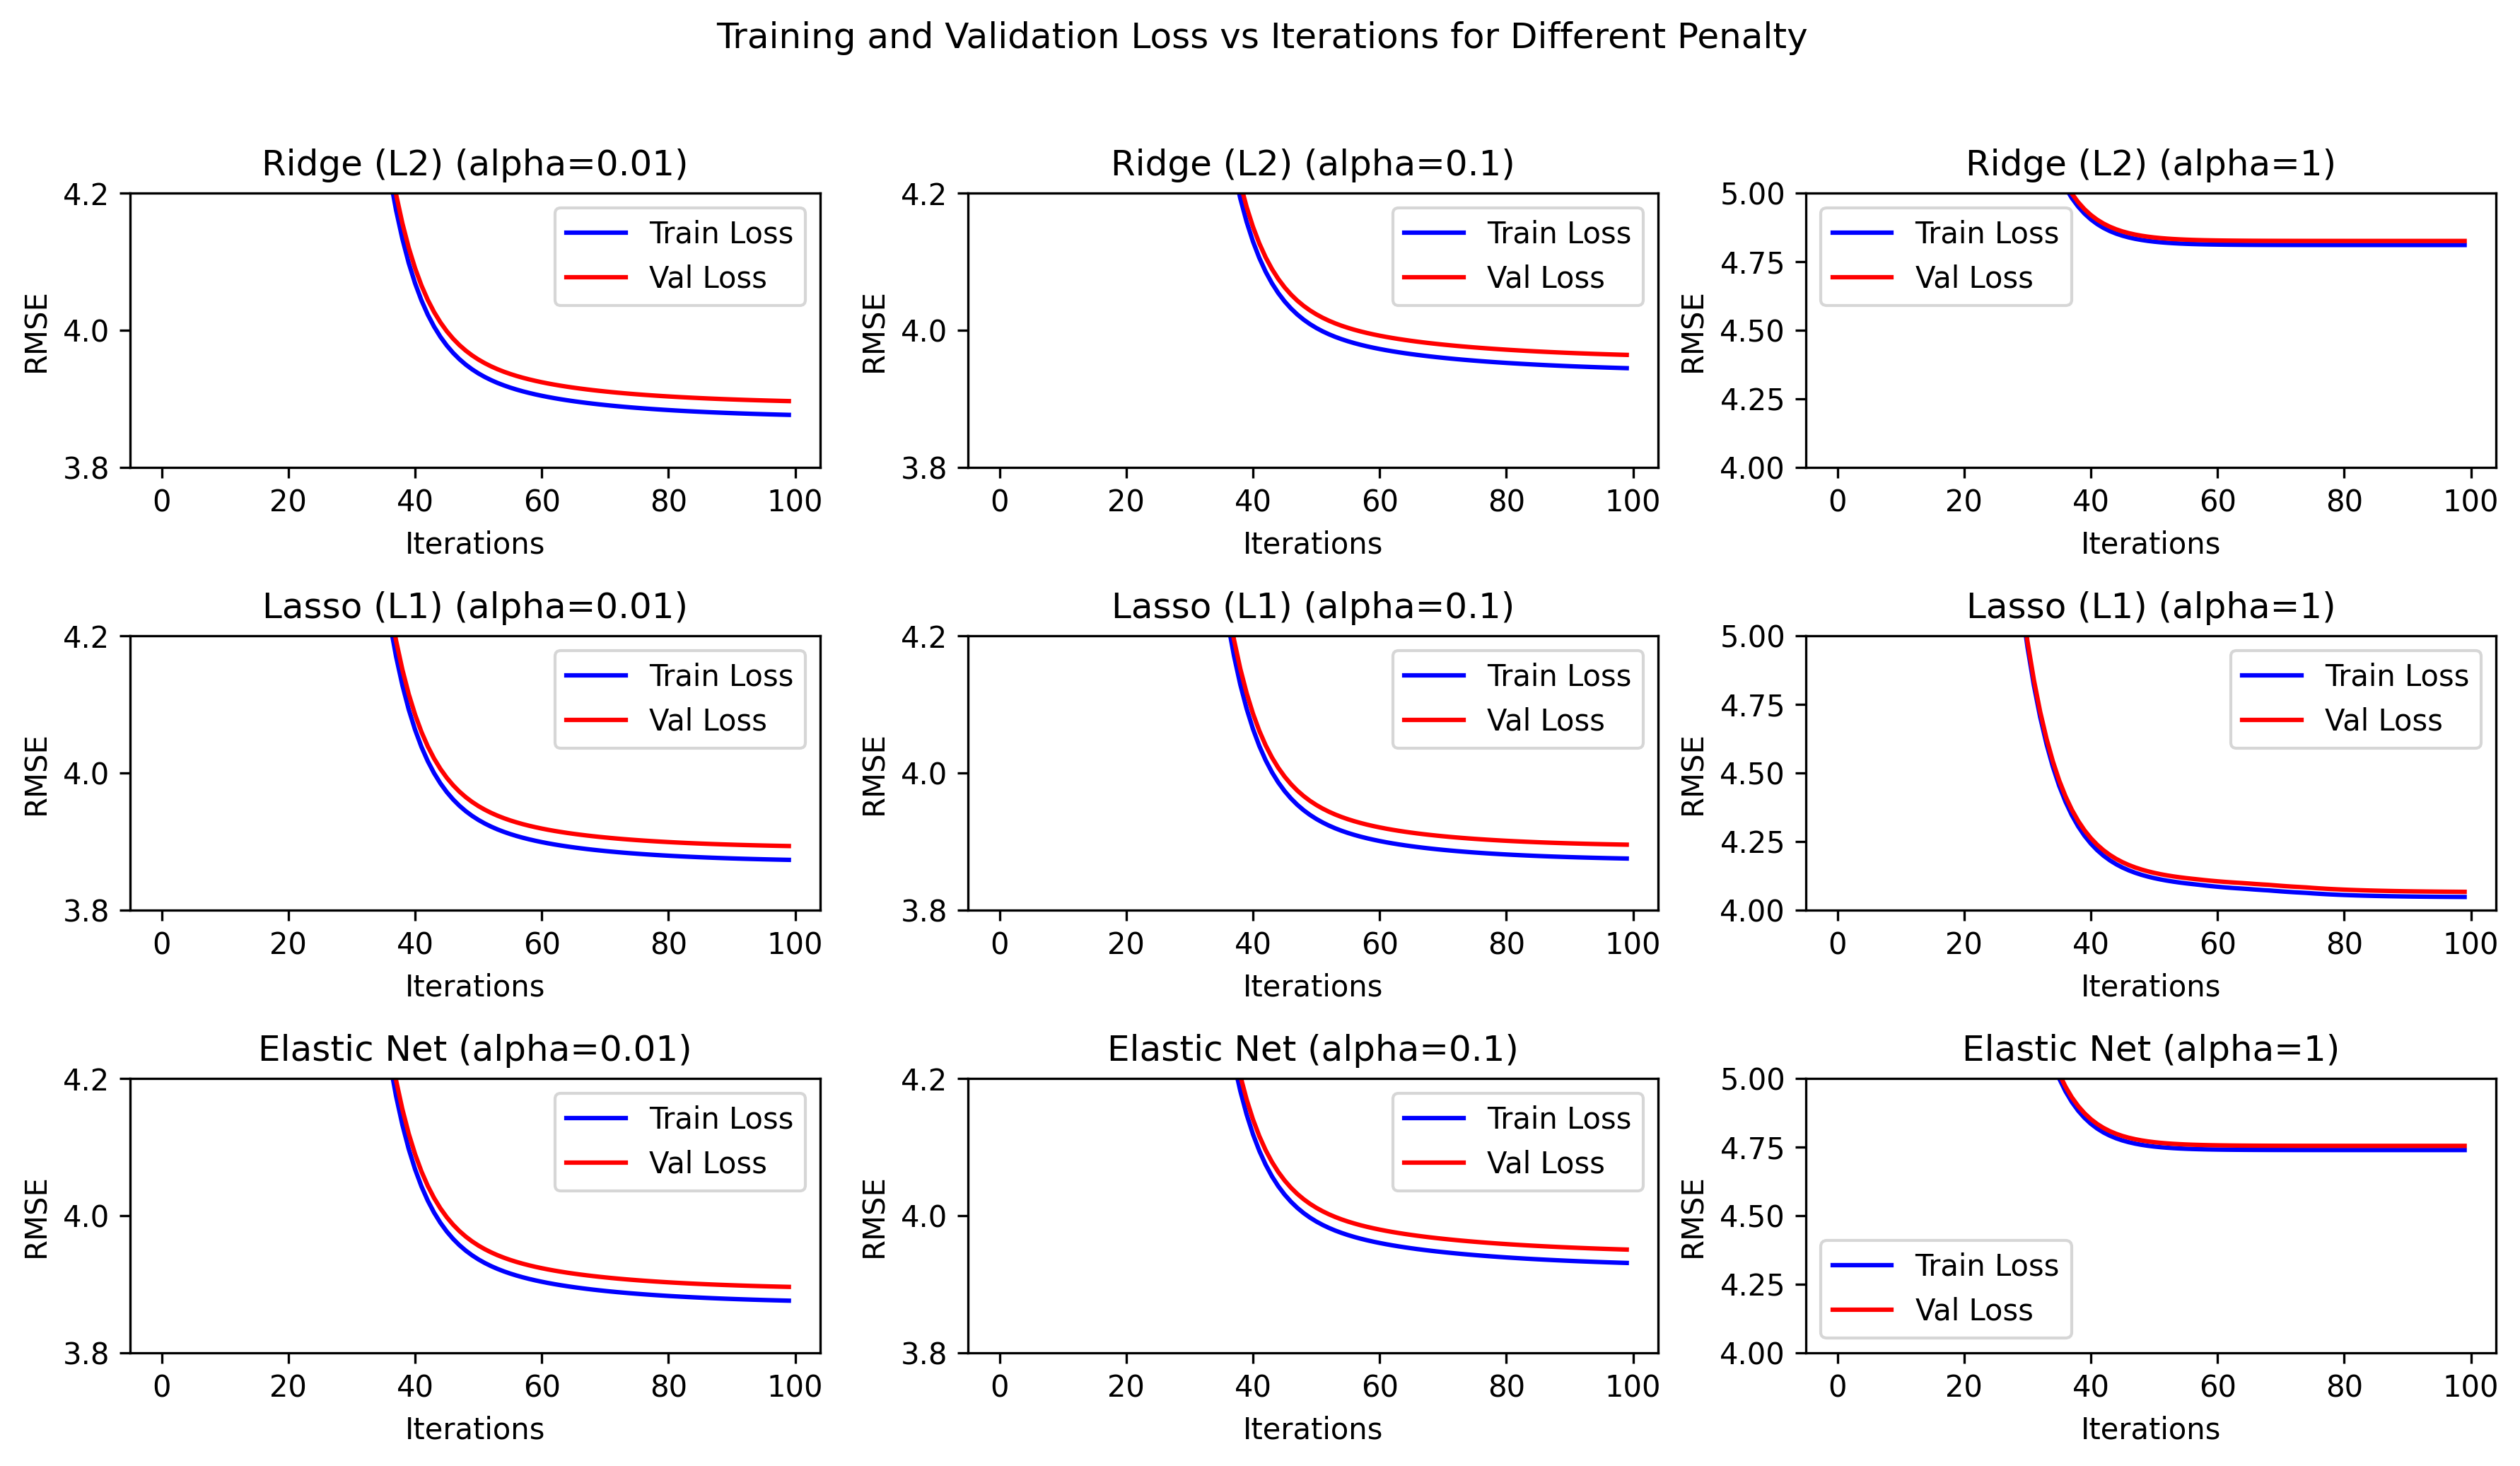

In [19]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types and penalty values
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}
penalty_values = [0.01, 0.1, 1]  # Three values for the penalty term

# Training iterations for tracking loss
n_iter = 100
eta0 = 0.0001  # Learning rate

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Penalty")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, alpha in enumerate(penalty_values):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations to track loss
            for _ in range(n_iter):
                sgd_reg.partial_fit(X_train_fold, y_train_fold)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (alpha={alpha})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        if j == 0:
            ax.set_ylim(3.8,4.2)
        if j == 1:
            ax.set_ylim(3.8,4.2)
        if j == 2:
            ax.set_ylim(4,5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

__Part 3: Hyper parameter tuning and Description__
- Batch_sizes:

In the process of machine learning and deep learning training, batch size directly affects the model’s convergence speed, optimization stability, and generalization ability, particularly in terms of gradient updates and loss function fluctuations.

- __1. Impact of Batch Size on Gradient Fluctuations__

__Small Batch Size (e.g., 8, 16)__:

- Greater gradient fluctuations: Since each mini-batch contains only a small number of samples, the computed gradient direction is easily influenced by random noise, leading to unstable and zigzagging updates.
- Better generalization ability: Although the gradient direction fluctuates more, this "noise" can help escape local optima, making the model more generalizable, especially for small datasets and non-convex optimization problems.
- Lower computational cost: Requires less memory, making it suitable for memory-constrained environments.

__Large Batch Size (e.g., 512, 1024)__:

- Smaller gradient fluctuations: A larger batch provides a more accurate estimate of the gradient, leading to more stable gradient directions and a smoother optimization path.
- Faster training speed: Each parameter update involves more data, allowing more efficient use of GPU parallel computing and improving throughput.
- More likely to get stuck in local optima: Since the gradient direction changes less, training may become trapped in local optima and struggle to escape.
- Potential decrease in generalization ability: Studies suggest that excessively large batch sizes may lead to reduced generalization ability (e.g., On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima).

__2. Relationship Between Batch Size and Loss Curve Fluctuations__

- Small batch: The loss function curve exhibits larger fluctuations, with significant oscillations during iterative updates.
- Large batch: The loss curve is smoother, but this may require adjusting the learning rate; otherwise, the convergence speed may slow down.

The following figures illustrate the training and validation MSE for different regularization methods (Ridge, Lasso, and Elastic Net) under varying batch sizes (batch_size = 8, 64, 512) as training progresses.

**1. Impact of Batch Size**

**Small Batch (batch_size = 8):**

- The training and validation loss decrease very slowly.
- The model does not fully converge within 500 iterations.
- Reason: Small batch sizes introduce more variance in gradient updates, leading to slower convergence.

**Medium Batch (batch_size = 64):**

- The model converges faster (~100 iterations), and the RMSE stabilizes around 4.0–4.8.
- The training and validation losses fluctuate moderately but remain close.
- Best balance between speed and stability.

**Large Batch (batch_size = 512):**

- The RMSE drops sharply within ~50 iterations, then stabilizes with small fluctuations.
- Convergence is fastest, but the final RMSE is slightly higher (~4.8–5.2).
- Reason: Larger batches provide smoother gradients, but the model might be biased due to lower update frequency.

**2. Impact of Regularization Methods:**

- Ridge (L2), Lasso (L1), and Elastic Net still show only minor differences in RMSE trends.
- However, Lasso and Elastic Net show more fluctuation in loss (especially for batch sizes 128 and 512).
- This is expected because L1-based regularization forces some coefficients to exactly zero, leading to more unstable updates in early iterations.
- Ridge (L2) appears slightly more stable in its convergence trend.

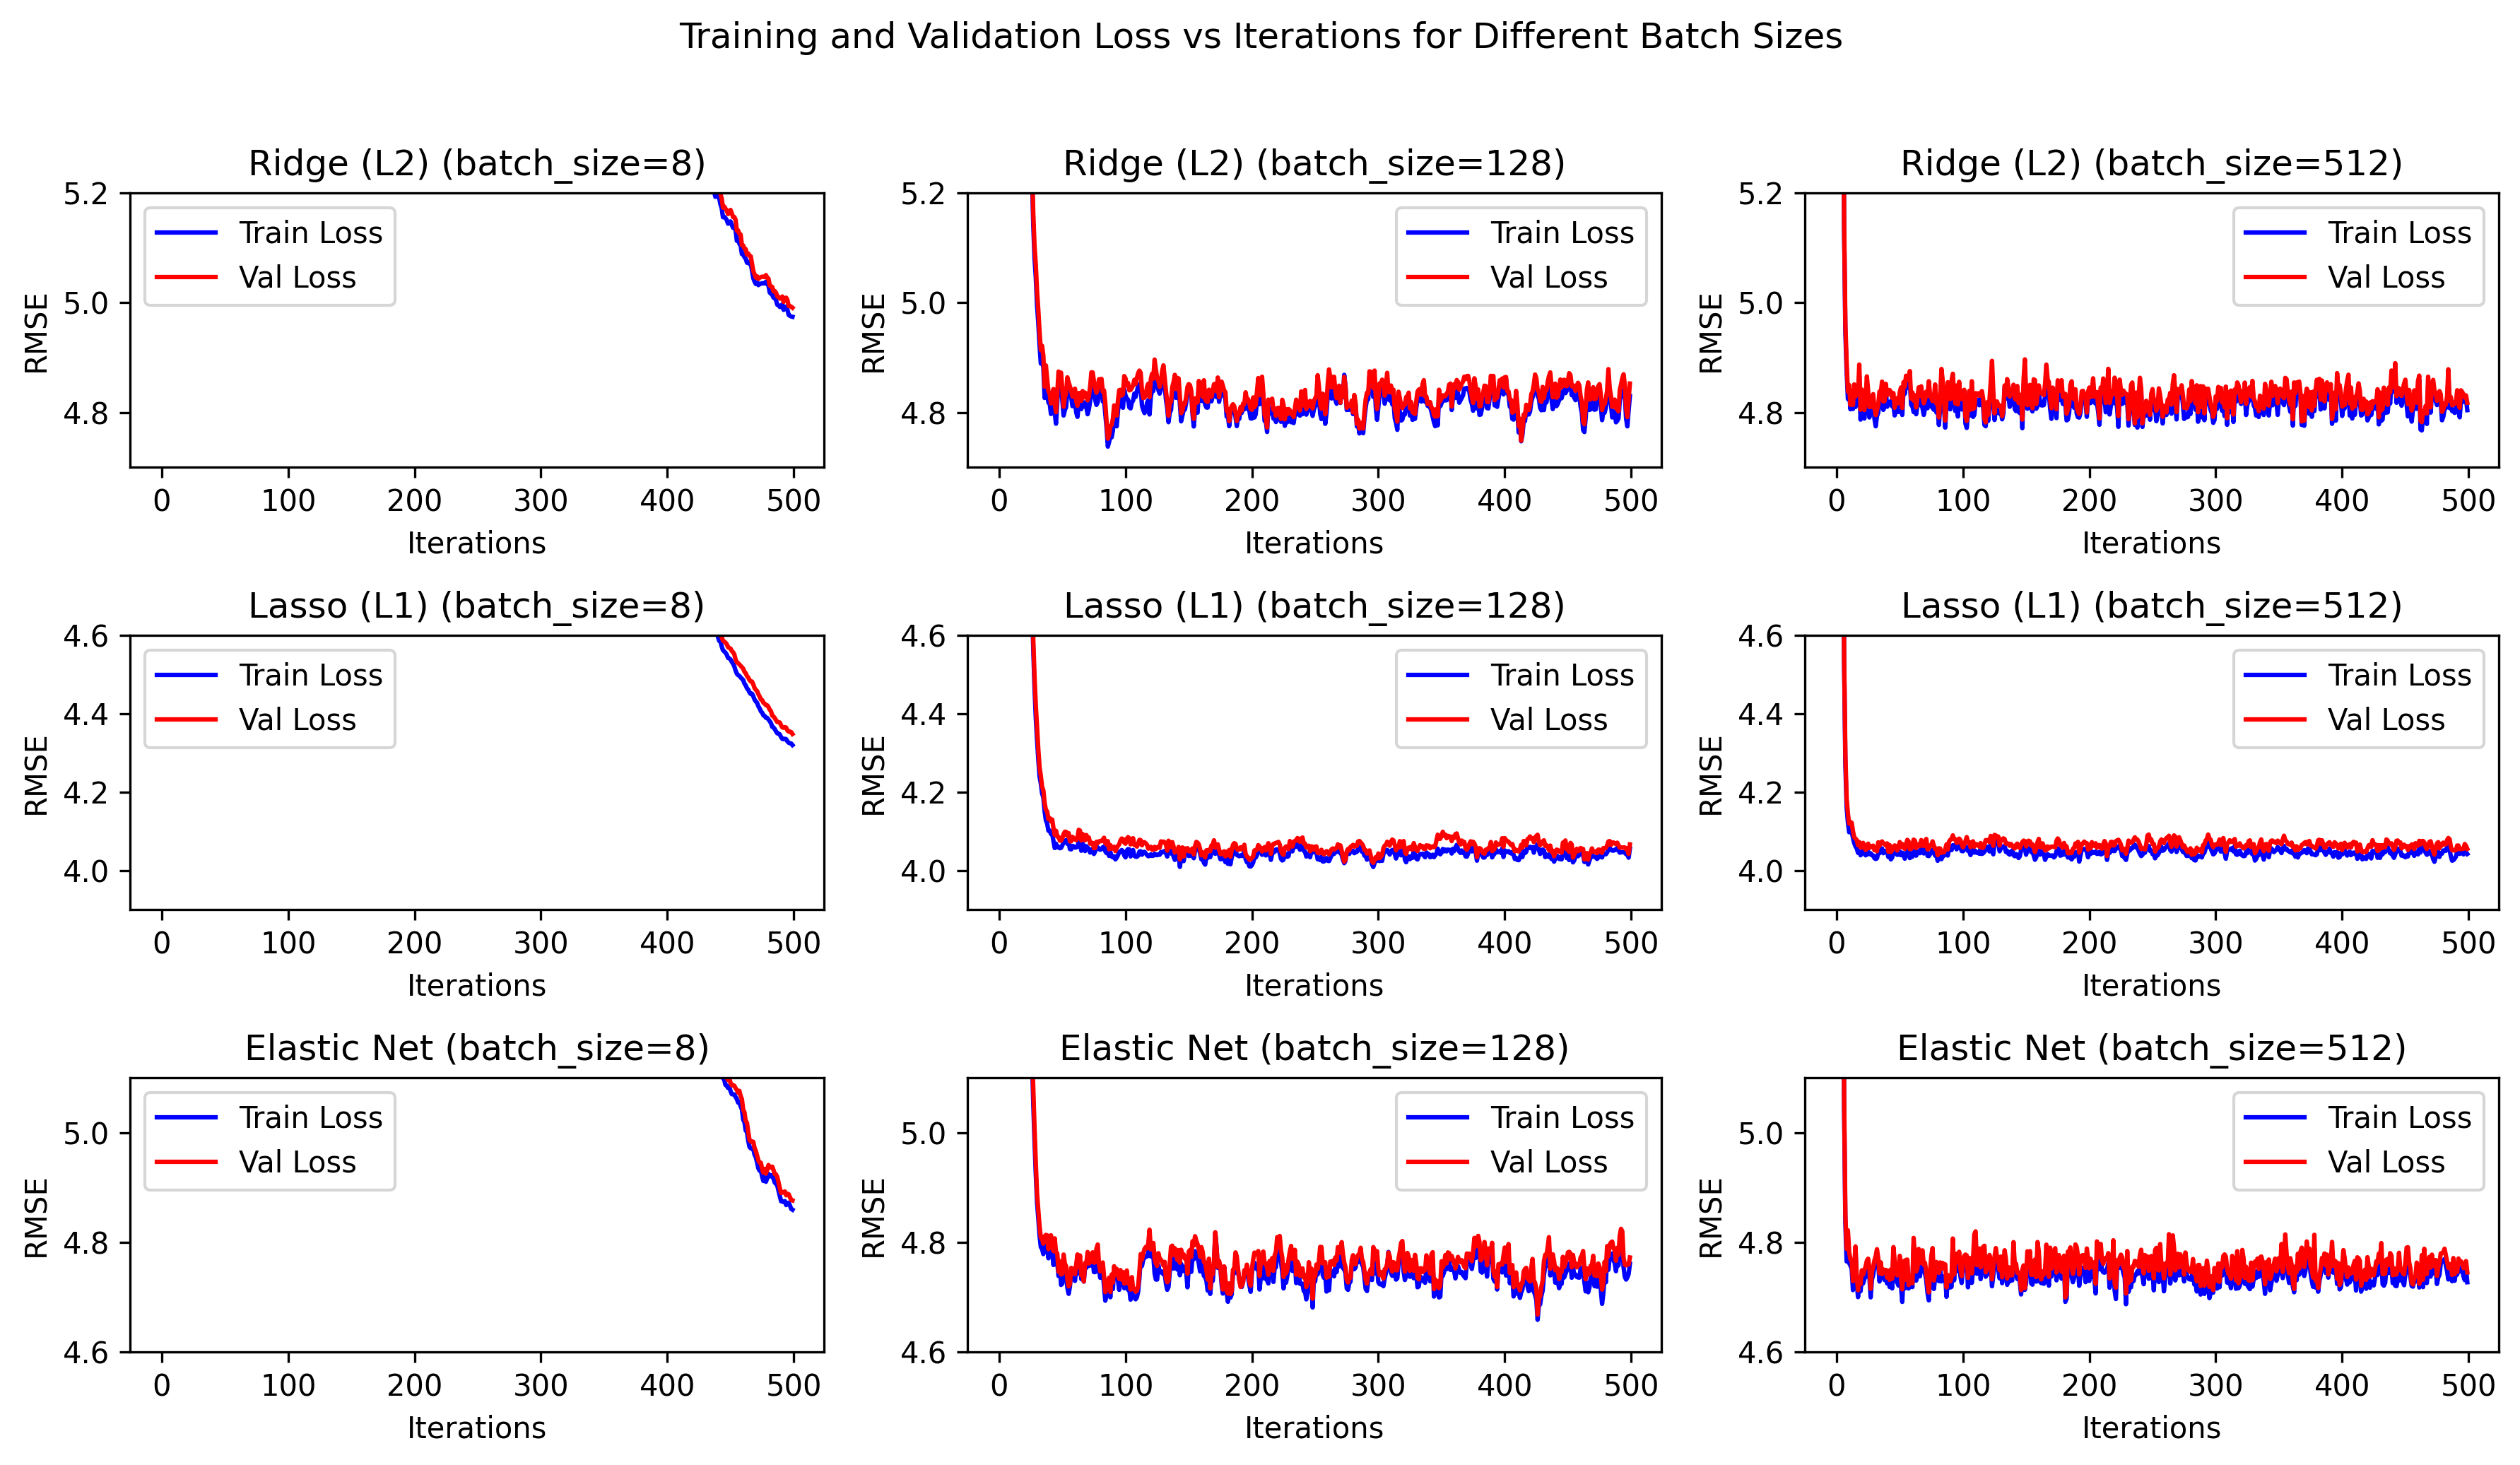

In [20]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed penalty value (alpha)
alpha = 1

# Batch sizes
batch_sizes = [8, 128, 512]

# Training iterations for tracking loss
n_iter = 500
eta0 = 0.001  

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Batch Sizes")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, batch_size in enumerate(batch_sizes):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type and batch size
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations to track loss
            for _ in range(n_iter):
                # Sample mini-batch
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)  
                X_batch, y_batch = X_train_fold[batch_indices], y_train_fold[batch_indices]

                # Train model on batch
                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (batch_size={batch_size})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        
        if i == 0:  
            ax.set_ylim(4.7, 5.2)
        elif i == 1:
            ax.set_ylim(3.9, 4.6)
        elif i == 2:
            ax.set_ylim(4.6, 5.1)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Learning rate:

The learning rate is one of the most critical hyperparameters in deep learning and machine learning optimization. It determines the step size for updating model parameters. The choice of learning rate significantly affects the convergence, stability, and final performance of the model.

1. **Excessively Large Learning Rate**  
   - Faster training speed: The model parameters update with a large step size, quickly reaching a relatively good solution.  
   - **Instability**: The model may oscillate near the optimal solution or even diverge, preventing convergence.  
   - **Failure to converge**: If the learning rate is too large, gradient descent may overshoot the optimal solution, potentially causing gradient explosion.  

2. **Excessively Small Learning Rate**  
   - **More stable training**: It prevents large parameter updates that could lead to oscillations or divergence.  
   - **Slow convergence**: The training time increases significantly, requiring a large number of epochs.  
   - **Risk of getting stuck in local optima**: A very small learning rate may cause the optimizer to stagnate near a local optimum, making it difficult to reach a better solution.

In this experiment, we tested three different learning rates (0.0001, 0.001, and 0.01) and observed the trends in training and validation loss. The results indicate that the learning rate has a significant impact on model convergence, as detailed below:

**1. Low Learning Rate (lr = 0.0001) – First Column**

- The RMSE decreases very slowly, and the model does not fully converge within 600 iterations.
- Training and validation loss remain high and almost unchanged for most iterations.
- A learning rate that is too small prevents fast convergence, leading to inefficient training.

**2. Moderate Learning Rate (lr = 0.001) – Middle Column**

- The model quickly converges within the first 100 iterations, then stabilizes.
- Training and validation loss remain close, indicating good generalization.
- This is the most optimal learning rate, achieving fast and stable convergence.

**3. High Learning Rate (lr = 0.1) – Third Column**

- The RMSE fluctuates drastically instead of decreasing smoothly.
- Both training and validation losses exhibit extreme oscillations, suggesting unstable updates.
- A learning rate that is too large causes gradient updates to overshoot, leading to divergence and chaotic behavior.

**Comparison Across Regularization Methods**

**1. Ridge (L2) Regularization**

- Shows smooth and stable convergence for lr=0.0001 and lr=0.001.
- For lr=0.1, the loss oscillates, but it is slightly less chaotic than Lasso and Elastic Net.

**2. Lasso (L1) Regularization**

- Exhibits similar trends as Ridge but with slightly more fluctuations in loss (especially in lr=0.001).
- For lr=0.1, the model becomes highly unstable, suggesting that L1 regularization might amplify sensitivity to large gradient updates.

**3. Elastic Net (Combination of L1 & L2)**

- A mix of Ridge and Lasso, its behavior is intermediate between the two.
- With lr=0.1, it still exhibits extreme oscillations, indicating that even combining L1 and L2 regularization does not prevent instability from high learning rates.

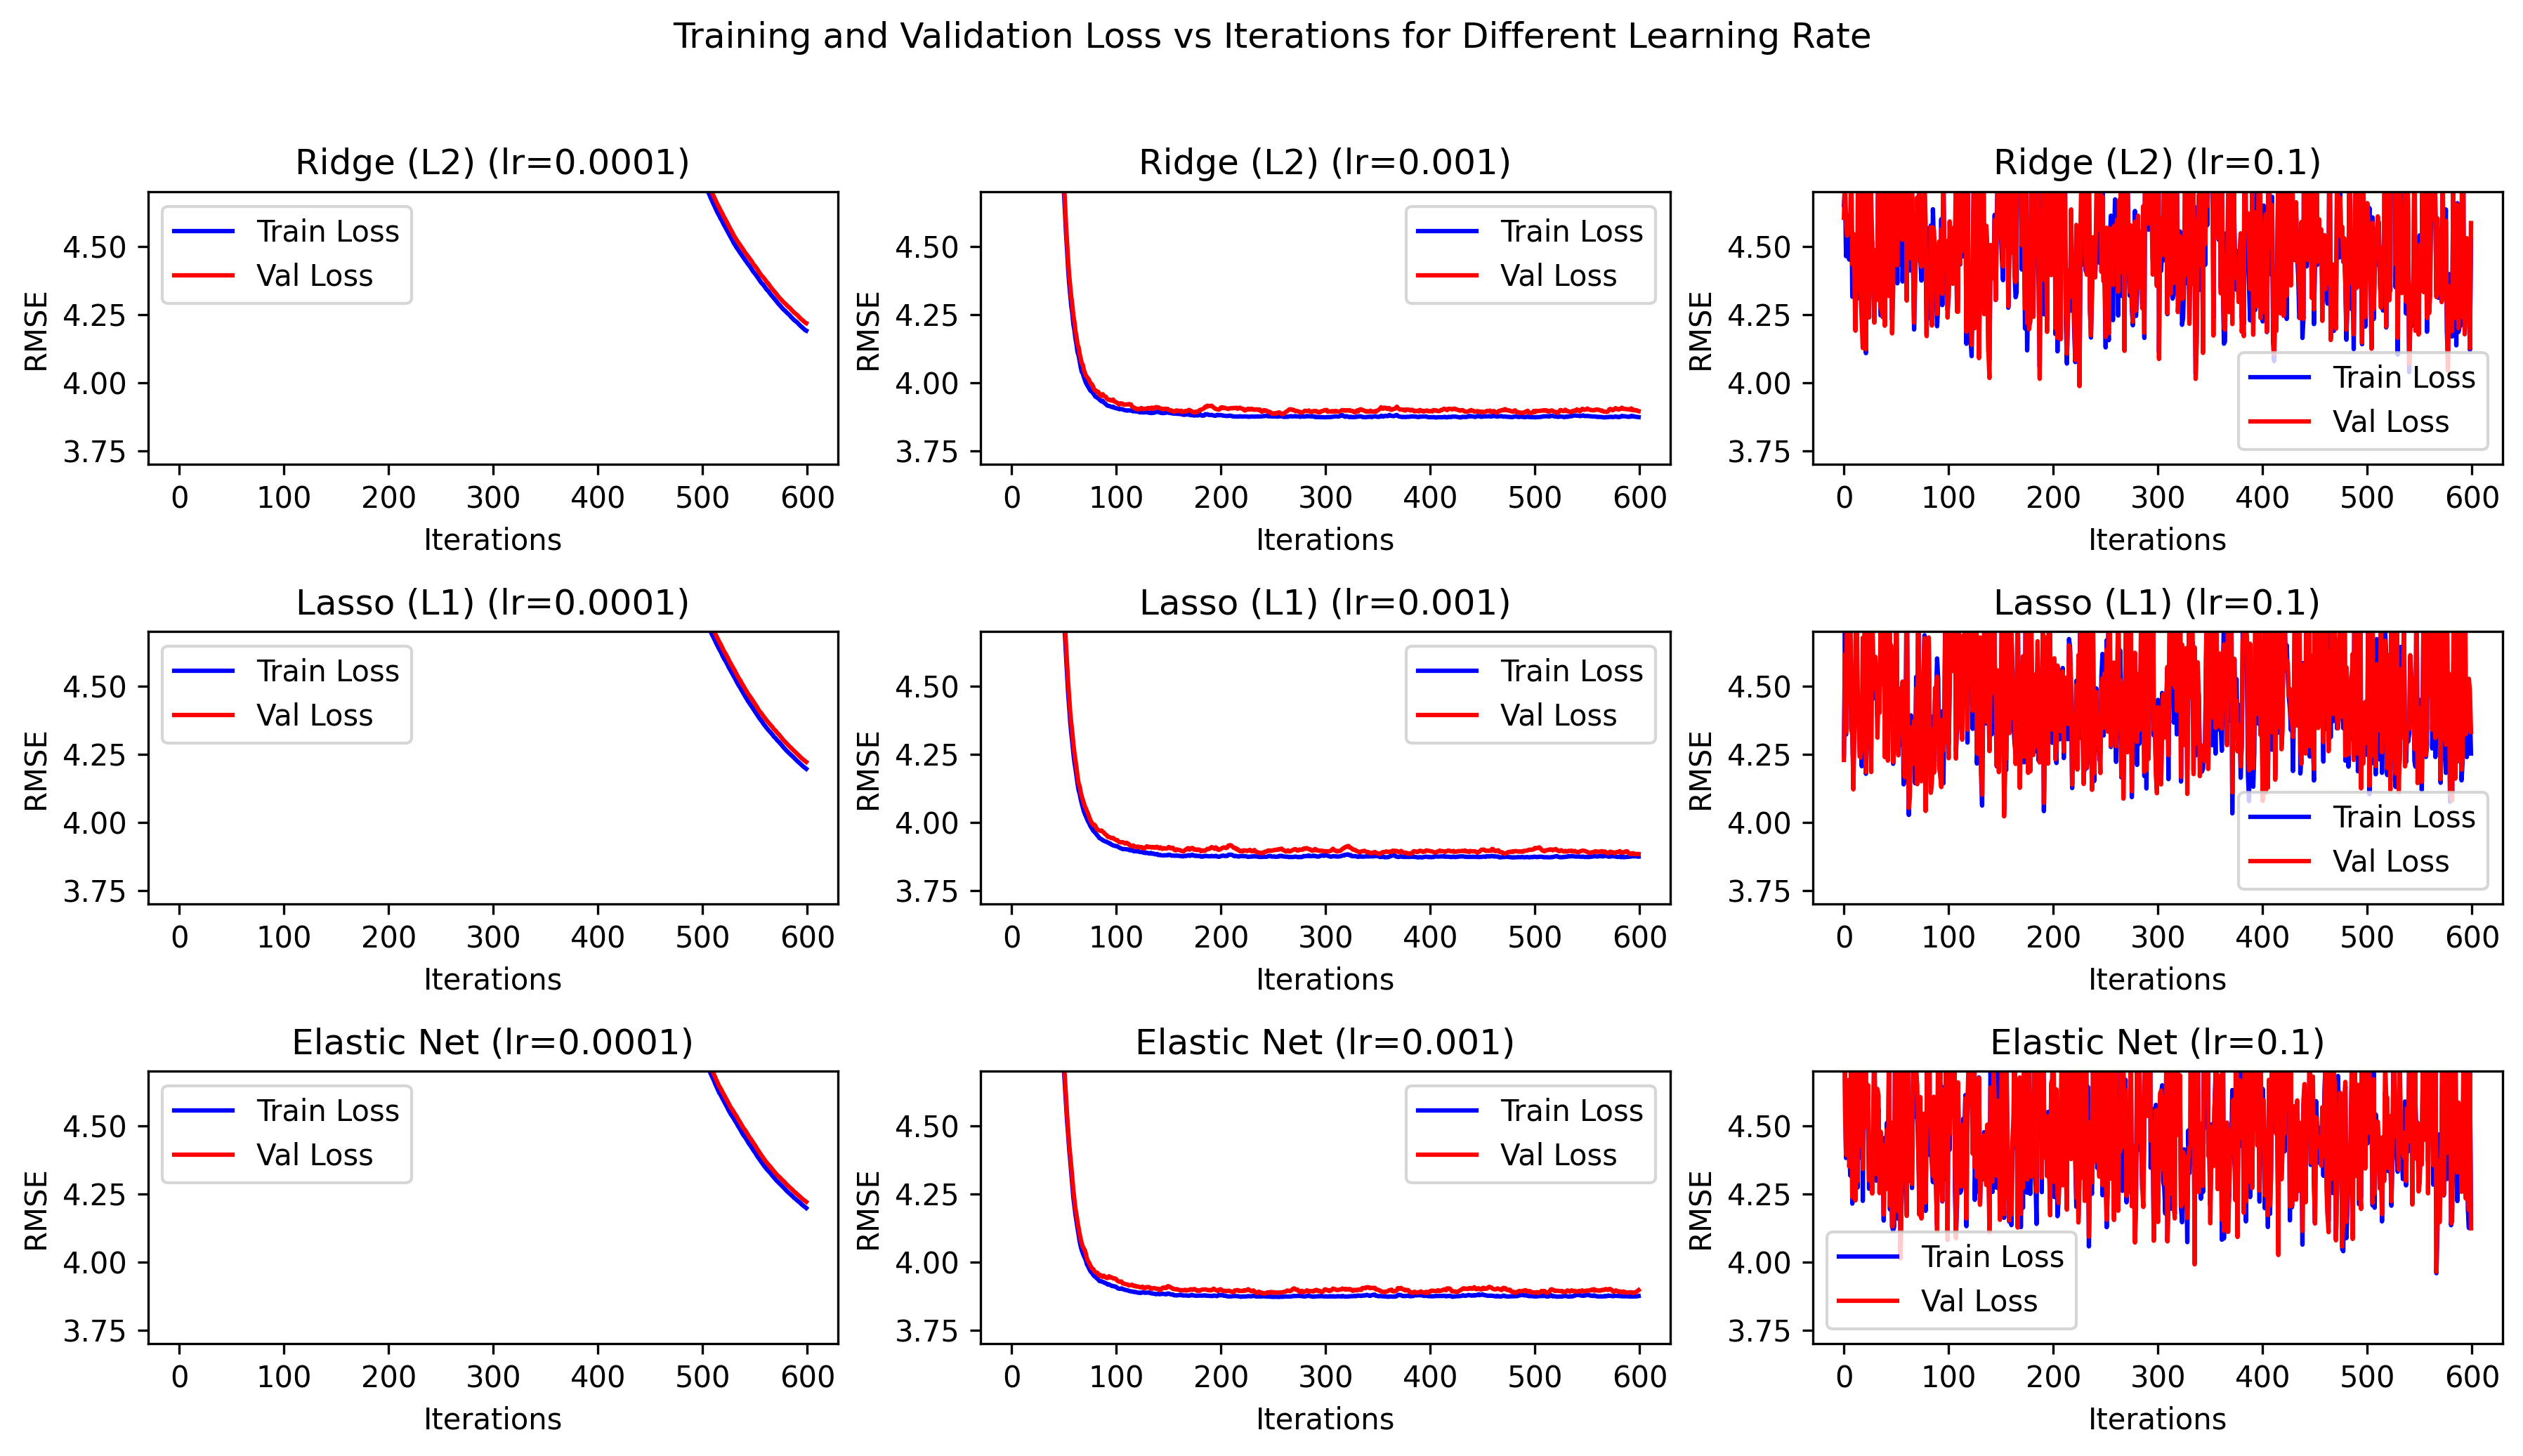

In [21]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed penalty value
alpha = 0.01  

# Batch size for mini-batch training
batch_size = 64

# Learning rates to test
learning_rates = [0.0001, 0.001, 0.1]

# Training iterations for tracking loss
n_iter = 600

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Learning Rate")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, eta0 in enumerate(learning_rates):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type and learning rate
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations using mini-batch gradient descent
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch, y_batch = X_train_fold[batch_indices], y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (lr={eta0})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(3.7, 4.7)  

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### F. Repeat everything from part E with polynomial regression and using SGD. Using validation loss, explore if your model overfits/underfits the data and report your findings. [10 points]

__Part 1 Regression: Polynomial Model using SGD (train and val loss)__

In [22]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up K-Fold Cross-validation (4 folds)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store RMSE results
train_rmse_results = []
val_rmse_results = []

# Loop over polynomial degrees from 1 to 10
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    train_rmse_folds = []
    val_rmse_folds = []

    # Perform 4-fold cross-validation
    for train_index, val_index in kf.split(X_train_poly):
        X_train_fold, X_val_fold = X_train_poly[train_index], X_train_poly[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train using Normal Equation (Linear Regression)
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_fold, y_train_fold)

        # Predict on training set
        y_train_pred = lin_reg.predict(X_train_fold)
        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

        # Predict on validation set
        y_val_pred = lin_reg.predict(X_val_fold)
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    # Store mean RMSE for this degree
    train_rmse_results.append(np.mean(train_rmse_folds))
    val_rmse_results.append(np.mean(val_rmse_folds))

__Low-Degree Polynomials (Degree 1-4)__

- Both training and validation RMSE remain low and close to each other.
- The model is underfitting slightly but maintains good generalization.
- This indicates that a low-degree polynomial (e.g., linear regression or quadratic) fits the data well.
- The error is relatively stable and small, meaning the model captures the underlying trend without excessive complexity.

__Medium-Degree Polynomials (Degree 5-6)__

- Training RMSE stays low, but validation RMSE starts to increase.
- The model is starting to overfit the training data.
- The polynomial model begins to capture noise rather than meaningful patterns.
- Training error remains low because the model memorizes the training data, but validation error increases because the model fails to generalize.

__High-Degree Polynomials (Degree >7)__

- Training RMSE remains low, indicating the model fits the training data very well.
- Validation RMSE increases sharply, showing a dramatic decrease in generalization.
- The model has become highly complex, capturing noise rather than true patterns.
- This results in poor generalization to new data, leading to a sharp increase in validation error.
- This is a classic case of overfitting, where the model becomes too flexible and unstable.

__Key Point__

- Degree 1-4 → Good fit:
The model generalizes well with low training and validation error.
- Degree 5-6 → Overfitting begins:
The model starts to memorize the training data, causing validation RMSE to rise.
- Degree >7 → Severe overfitting:
The model captures noise instead of meaningful patterns, causing poor validation performance.

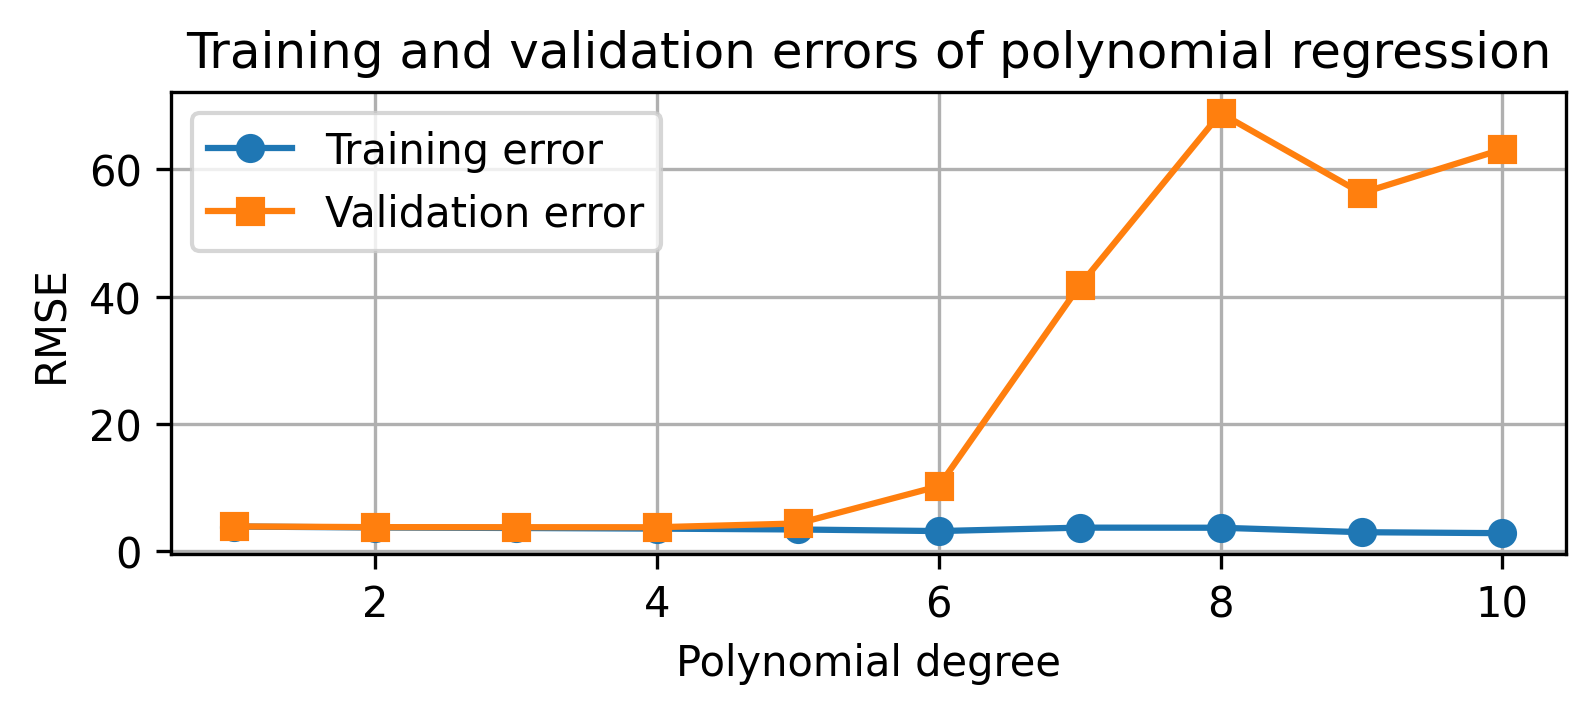

In [23]:
# Plot the error curves
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(list(range(1, 11)), train_rmse_results, marker='o', label="Training error")
plt.plot(list(range(1, 11)), val_rmse_results, marker='s', label="Validation error")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("Training and validation errors of polynomial regression")
plt.legend()
plt.grid()
plt.show()

In [24]:
# Store RMSE results
train_rmse_sgd = []
val_rmse_sgd = []

# Loop over polynomial degrees from 1 to 7 using SGDRegressor
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Feature scaling is crucial for SGD
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)

    train_rmse_folds = []
    val_rmse_folds = []

    # Perform 4-fold cross-validation
    for train_index, val_index in kf.split(X_train_poly_scaled):
        X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train using SGDRegressor with a small learning rate for stability
        sgd_reg = SGDRegressor(max_iter=1000, eta0=0.001, learning_rate="constant", random_state=42)
        sgd_reg.fit(X_train_fold, y_train_fold)

        # Predict on training set
        y_train_pred = sgd_reg.predict(X_train_fold)
        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

        # Predict on validation set
        y_val_pred = sgd_reg.predict(X_val_fold)
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    # Store mean RMSE for this degree
    train_rmse_sgd.append(np.mean(train_rmse_folds))
    val_rmse_sgd.append(np.mean(val_rmse_folds))

**Observations from the SGD RMSE Plot**

**Low-Degree Polynomials (Degree 1-6)**

- Training and validation RMSE remain close and stable (~3.8 to 4.0).
- No overfitting is observed in this range.
- This indicates that SGD successfully fits the data for lower-degree polynomials.

**Higher-Degree Polynomials (Degree 7-10)**

- Both training and validation RMSE increase significantly.
- At degree 9 and 10, RMSE jumps to over 5.5, indicating overfitting.
- The trend is smoother than Normal Equation, but still follows the same pattern of increasing complexity leading to higher validation error.

**key Differences**
- Overfitting occurs more gradually in SGD.

  The Normal Equation method exhibited a sharp increase in validation RMSE beyond degree 5, while SGD overfits more gradually.
  This is likely due to SGD’s stochastic updates, which introduce slight regularization.
  
- SGD does not drive training error to zero.

  In the Normal Equation, the model memorizes training data completely at high degrees (degree 7+), leading to extremely low training error but high validation error.
  In SGD, training error remains relatively higher, meaning it does not fully memorize the training data, which reduces overfitting.
  
- SGD is computationally more efficient for high-degree polynomials.

  The Normal Equation involves matrix inversion, which becomes computationally expensive for high-degree polynomials.
  SGD scales better, making it preferable for large datasets.

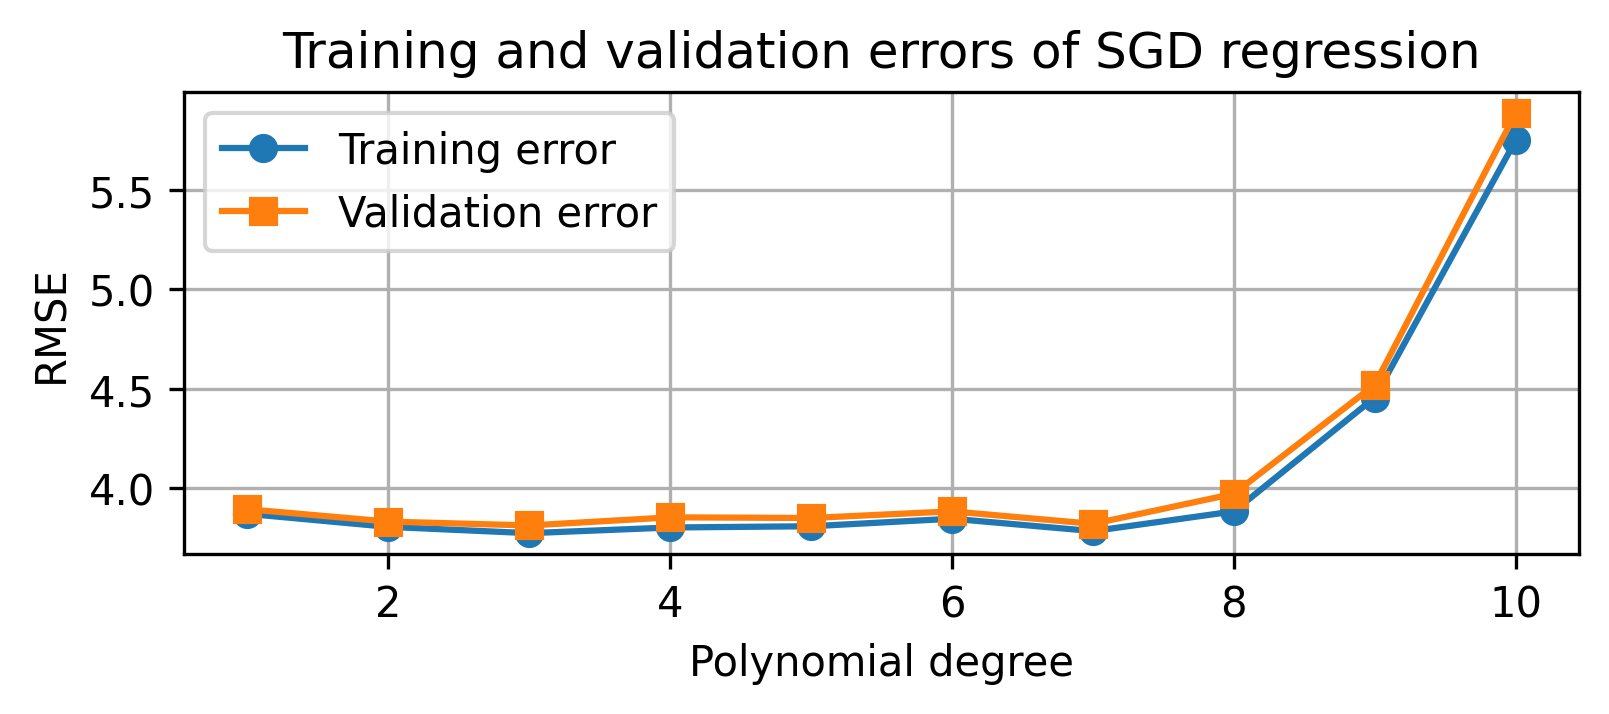

In [25]:
# Plot the error curves
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(list(range(1, 11)), train_rmse_sgd, marker='o', label="Training error")
plt.plot(list(range(1, 11)), val_rmse_sgd, marker='s', label="Validation error")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("Training and validation errors of SGD regression")
plt.legend()
plt.grid()
plt.show()

__Part 2 Regularization: Regularization with different penalty terms__

The following figure shows a second-degree polynomial regression (degree = 2) trained with SGD, applying Ridge (L2), Lasso (L1), and Elastic Net regularization with different values of alpha (0.001, 0.1, 10):

**1. Effect of alpha on Convergence**

**Small Regularization (alpha = 0.001):**

- The training and validation loss decrease smoothly, with stable final RMSE (~3.8 - 4.0).
- Training and validation curves remain closely aligned, suggesting good generalization.
- The model is more flexible and captures more variance in the data.

**Moderate Regularization (alpha = 0.01):**

- Convergence behavior is similar to alpha = 0.001, but final RMSE is slightly higher.
- The loss curves are still smooth and stable, but the model is slightly more constrained.
- This may prevent overfitting while still allowing flexibility.

**Strong Regularization (alpha = 1):**

- Higher RMSE (~4.2 - 4.4) compared to smaller alpha values.
- Loss curves become noisier, indicating less stability in convergence.
- The model is highly constrained, potentially leading to underfitting.
- Training and validation loss are almost identical, but at the cost of worse predictive performance.

**2. Effect of Different Regularization Methods**

**Ridge (L2) Regularization:**

- Produces the smoothest loss curves, especially for alpha = 0.001 and 0.01.
- Even with alpha = 1, Ridge remains relatively stable, though with higher RMSE.
- Best suited for preventing overfitting while maintaining model flexibility.

**Lasso (L1) Regularization:**

- Similar convergence trends as Ridge for alpha = 0.001 and 0.01, but with more fluctuations in the loss curves.
- For alpha = 1, the loss curves are noisier, suggesting that some feature coefficients are being forced to zero (sparsity effect).
- More unstable at higher alpha values, but beneficial for feature selection.

**Elastic Net (L1 + L2 Combined):**

- -Convergence behavior is between Ridge and Lasso.
- For alpha = 1, it is noisier than Ridge but slightly more stable than Lasso.
- Balances Ridge’s stability with Lasso’s sparsity.

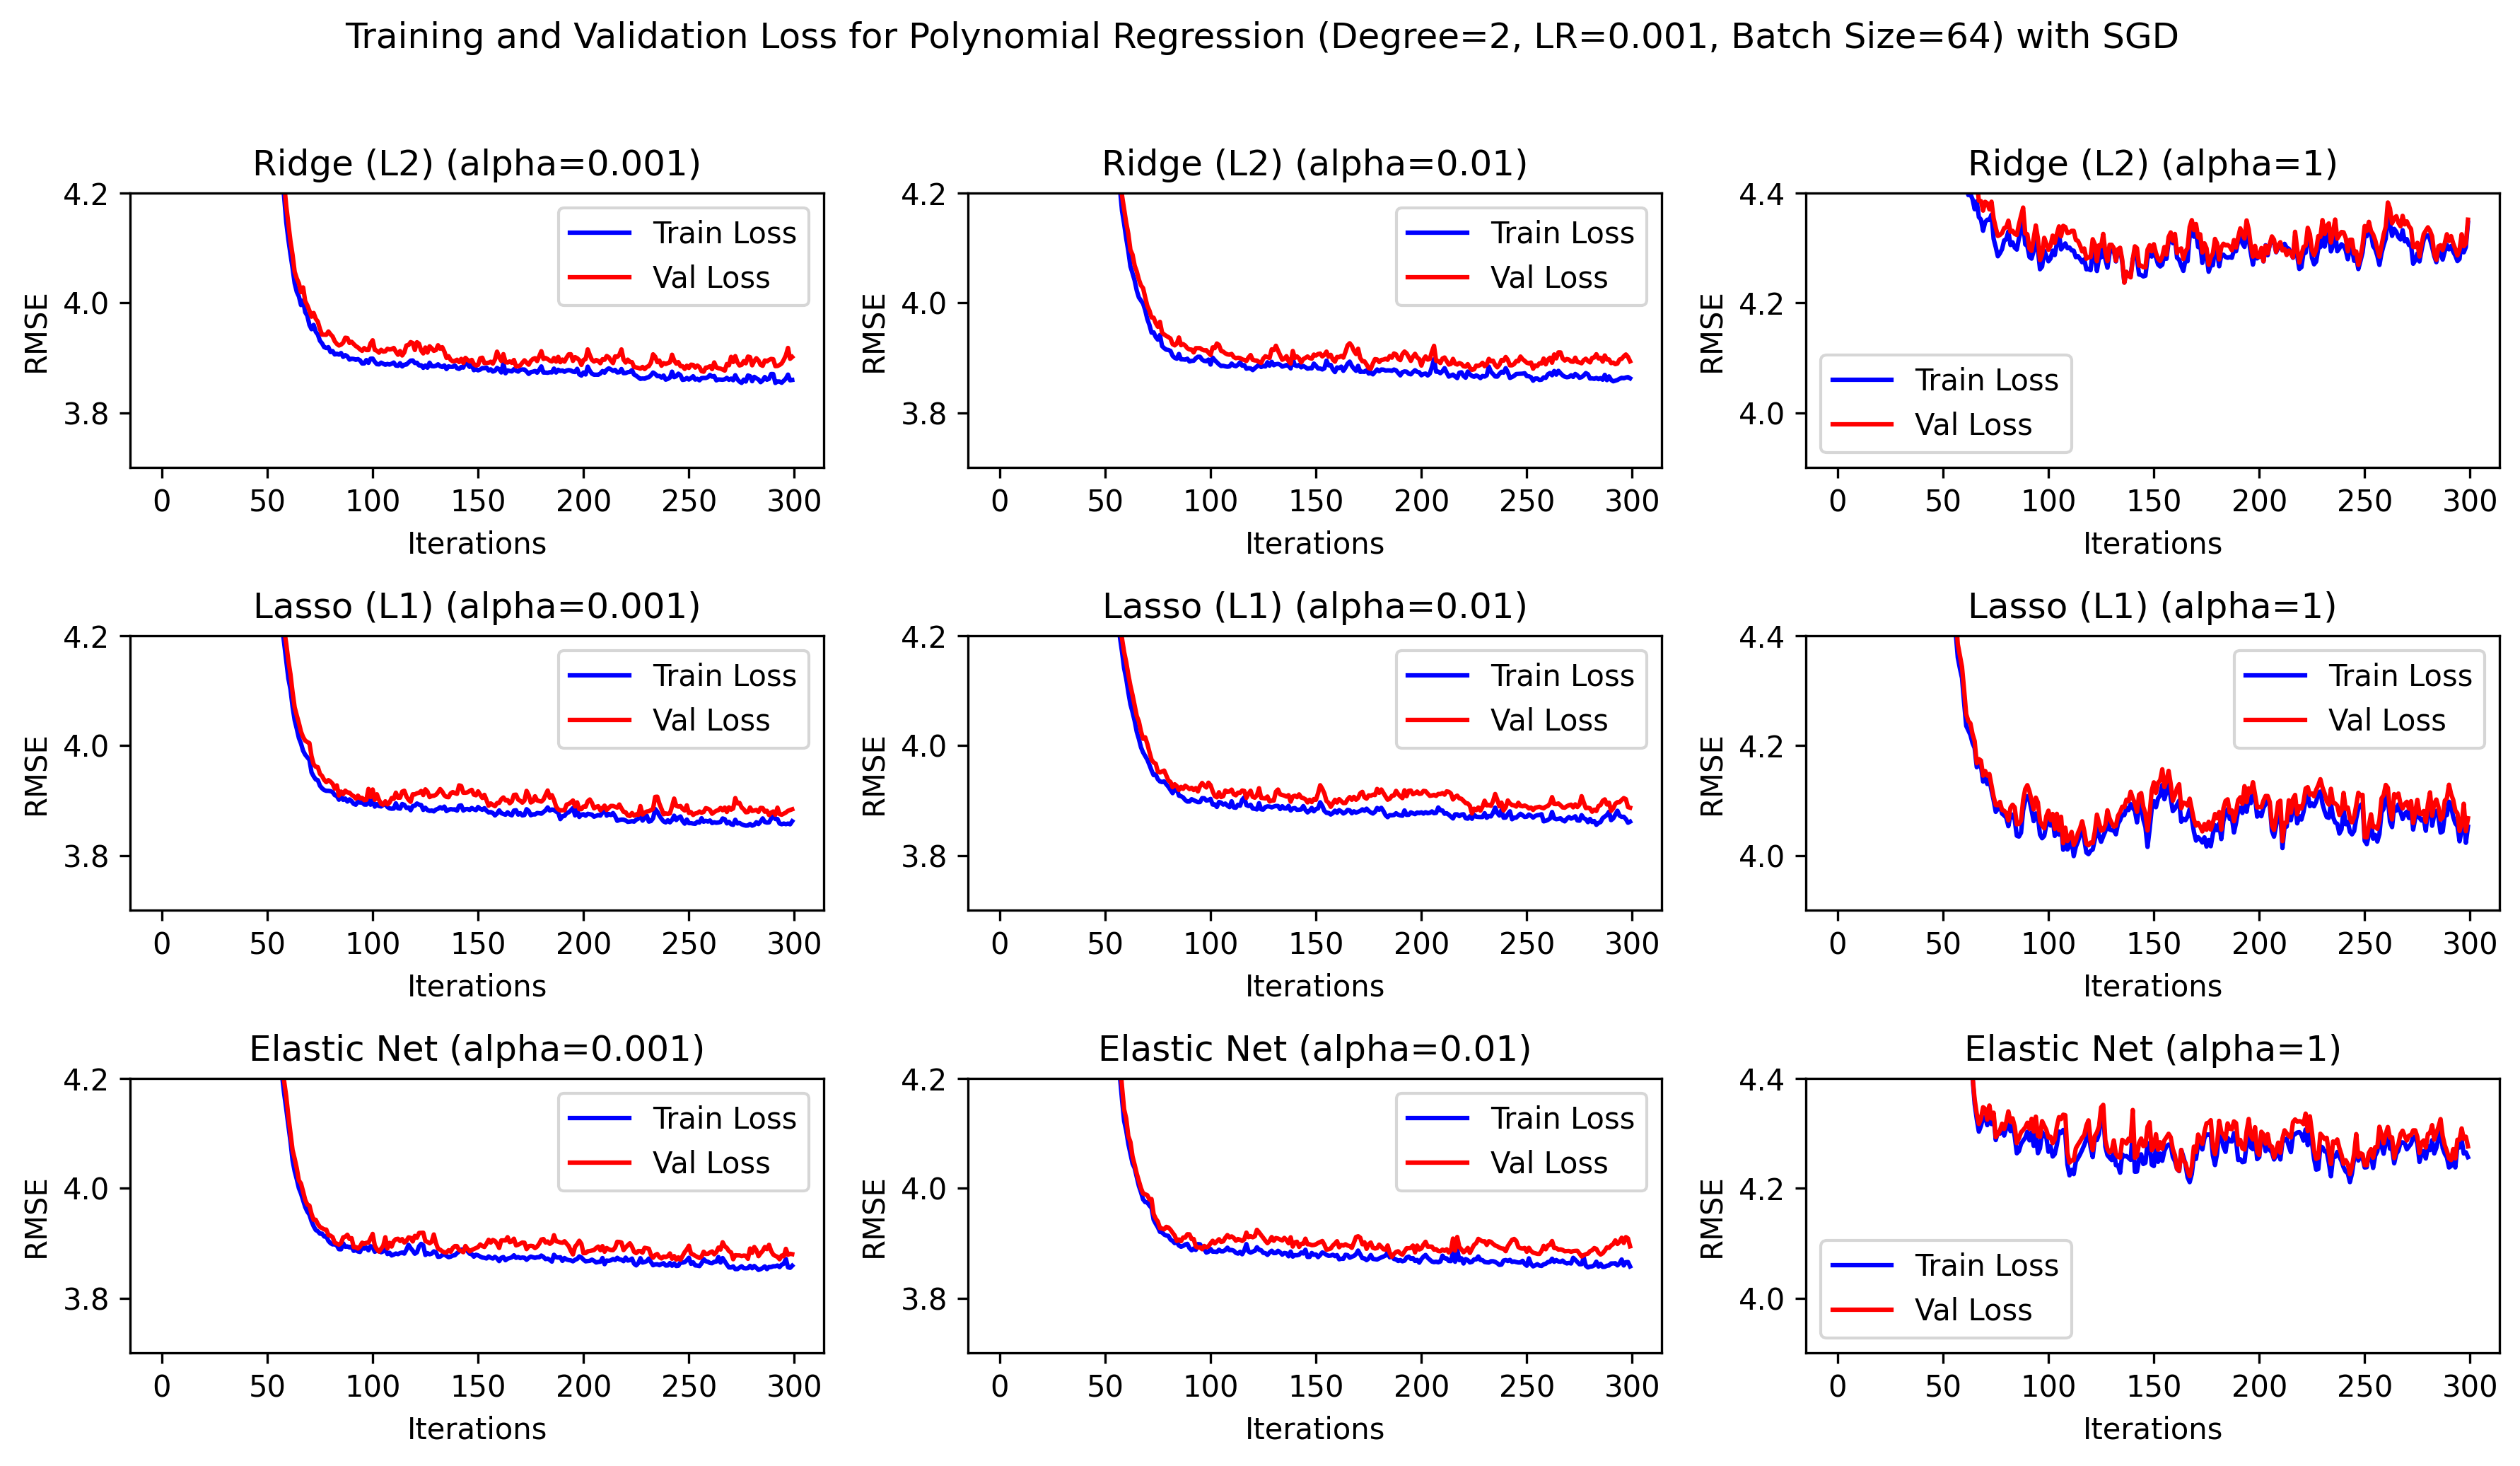

In [26]:
# Define regularization types and penalty values
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}
penalty_values = [0.001, 0.01, 1]  # Regularization strength values
learning_rate = 0.001  # Fixed learning rate
batch_size = 64  # Fixed batch size

# Set polynomial degree to 2
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Set training parameters
n_iter = 300  # Number of iterations

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression (Degree={degree}, LR={learning_rate}, Batch Size={batch_size}) with SGD")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, alpha in enumerate(penalty_values):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type, fixed learning rate, and batch size
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=learning_rate,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations with mini-batch processing
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (alpha={alpha})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(3.8, 4.5)
        if j == 0:  
            ax.set_ylim(3.7, 4.2)
        elif j == 1:
            ax.set_ylim(3.7, 4.2)
        elif j == 2:
            ax.set_ylim(3.9, 4.4)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


__Part 3: Hyper parameter tuning and Description__
- Batch_sizes:

The following figure shows a second-degree polynomial regression (degree = 2) trained with SGD, under different regularization methods (Ridge, Lasso, Elastic Net) and batch sizes (8, 128, 1024), displaying the training and validation RMSE trends over iterations.

**Effect of Batch Size on Convergence**

**Small Batch Size (8)**

- RMSE decreases slowly in a linear trend, with a slow convergence rate per iteration.
- Training and validation curves almost overlap, indicating stable training but low efficiency.
- Potential issue: Training takes longer and requires more iterations to achieve good performance.
- High variance in gradient updates, as each update uses only 8 samples, leading to more randomness in parameter updates.
- This may cause unstable convergence, but can help the model escape local minima.

**Medium Batch Size (128)**
- RMSE decreases exponentially, and the training process is smooth.
- Fastest and most stable convergence, with the smallest gap between training and validation RMSE, indicating the best generalization.
- Balances stability and update frequency, reducing noise from small batches while maintaining a fast training speed.
- Optimal choice, allowing for efficient model training and strong test performance.

**Large Batch Size (1024)**
- RMSE drops sharply in the first few iterations, then remains nearly unchanged.
- Training and validation RMSE are very close, but training finishes too quickly.
- Potential issue: The model may converge prematurely before reaching the global optimal solution.
- Batch size is too large, making updates overly stable and prone to getting stuck in local minima.
- Training is fast, but the model may struggle to generalize to new data.

**Effect of Regularization on Convergence**  

- The model (degree = 2) is already stable and does not easily overfit.  
- Regularization has a more significant impact on higher-degree polynomials (e.g., degree = 5+).  
- L2 (Ridge) ensures stable convergence, but its impact is minimal.  
- L1 (Lasso) may shrink some feature weights to zero, but its effect is not noticeable in this dataset.  
- Elastic Net combines both L1 and L2 regularization, but its behavior is similar to Ridge and Lasso in this case.  

**Conclusion**  
- For a degree = 2 model, regularization does not have a strong effect.  
- Regularization will be more effective for higher-degree polynomial models (degree = 5+).

*Note  I set `ylim(3.2, 4.4)` to display the `Train loss` and `Val loss`; otherwise, if the `ylim` is too large, the two lines cannot be distinguished.

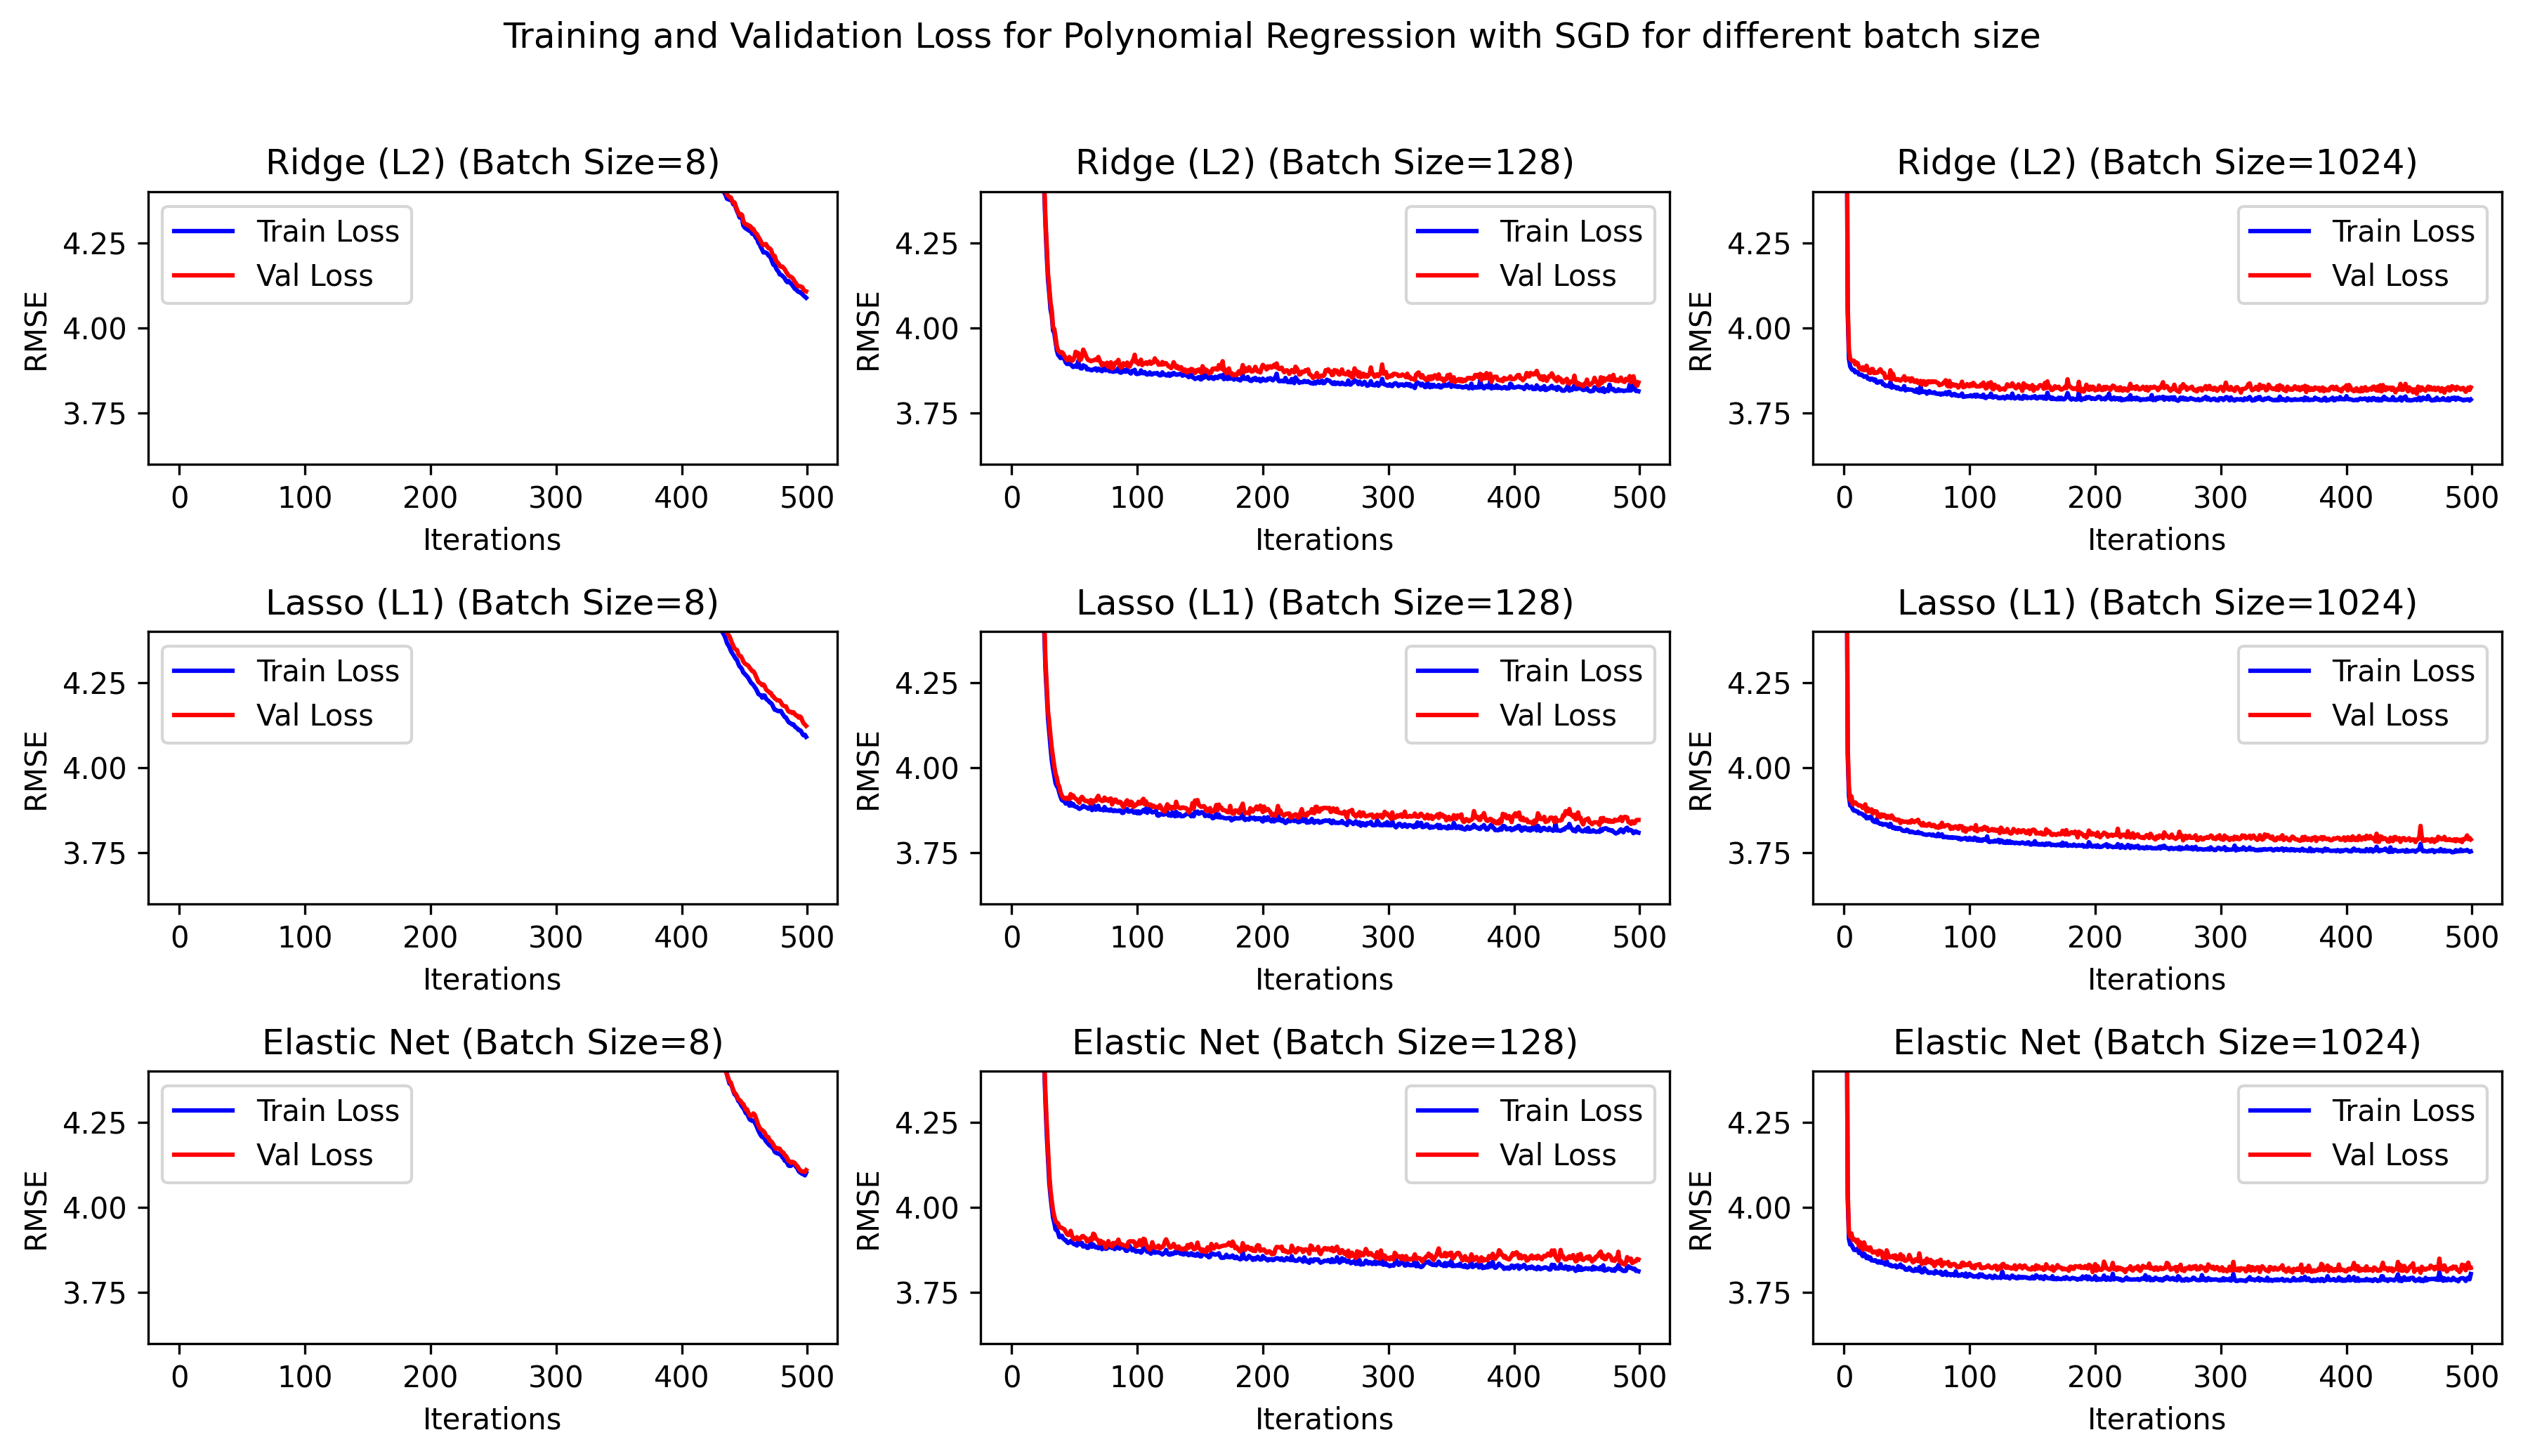

In [27]:
# Define batch sizes and regularization types to test
batch_sizes = [8, 128, 1024]
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed settings
degree = 2  # Fixed polynomial degree
alpha = 0.01  # Fixed regularization strength
eta0 = 0.001  # Learning rate
n_iter = 500  # Number of iterations

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression with SGD for different batch size")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, batch_size in enumerate(batch_sizes):
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with mini-batch processing
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train using mini-batch SGD
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (Batch Size={batch_size})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(3.6, 4.4)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- Learning rate:

**Effect of Learning Rate on Convergence**

**For Learning Rate = 0.0001 & 0.001:** Training and validation RMSE remain close, this suggests the model generalizes well and does not memorize noise. A well-regularized and balanced model.

**Possible slight overfitting for Learning Rate = 0.01:** Validation loss fluctuates more than training loss, which suggests instability. The model adapts too quickly, potentially fitting noise rather than meaningful trends.

**Low Learning Rate (0.0001)**

- RMSE decreases very slowly, and the model has not fully converged even after 600 iterations.
- The training and validation curves overlap closely, indicating stable learning.
- The loss is still decreasing at the end, meaning more iterations are needed for full convergence.
- Small updates make the optimization process slow. However, this prevents divergence and ensures stability.
- Best choice if you have more iterations available.

**Medium Learning Rate (0.001)**

- RMSE drops quickly within the first ~100 iterations, then stabilizes.
- The training and validation curves remain close, indicating good generalization.
- Fastest and most stable convergence among all learning rates.
- Well-balanced updates allow the model to reach an optimal solution quickly. Best trade-off between speed and stability.
- Optimal learning rate for this dataset.

**High Learning Rate (0.01)**

- RMSE drops sharply at the beginning but starts oscillating.
- Validation loss fluctuates significantly, suggesting unstable training.
- The model may not be converging properly, indicating poor generalization.
- Updates are too large, causing the model to overshoot the optimal solution. High variance in updates leads to instability.

**Effect of Regularization on Convergence**

- Ridge (L2): Helps stabilize updates, especially at higher learning rates.
- Lasso (L1): May zero out some features, but no major effect at degree = 2.
- Elastic Net: Balances Ridge and Lasso, behaving similarly in this case.
- At degree = 2, regularization type does not have a major impact. Regularization will matter more in higher-degree polynomial models.

*Note  I set `ylim(3.5, 4.5)` to display the `Train loss` and `Val loss`; otherwise, if the `ylim` is too large, the two lines cannot be distinguished.

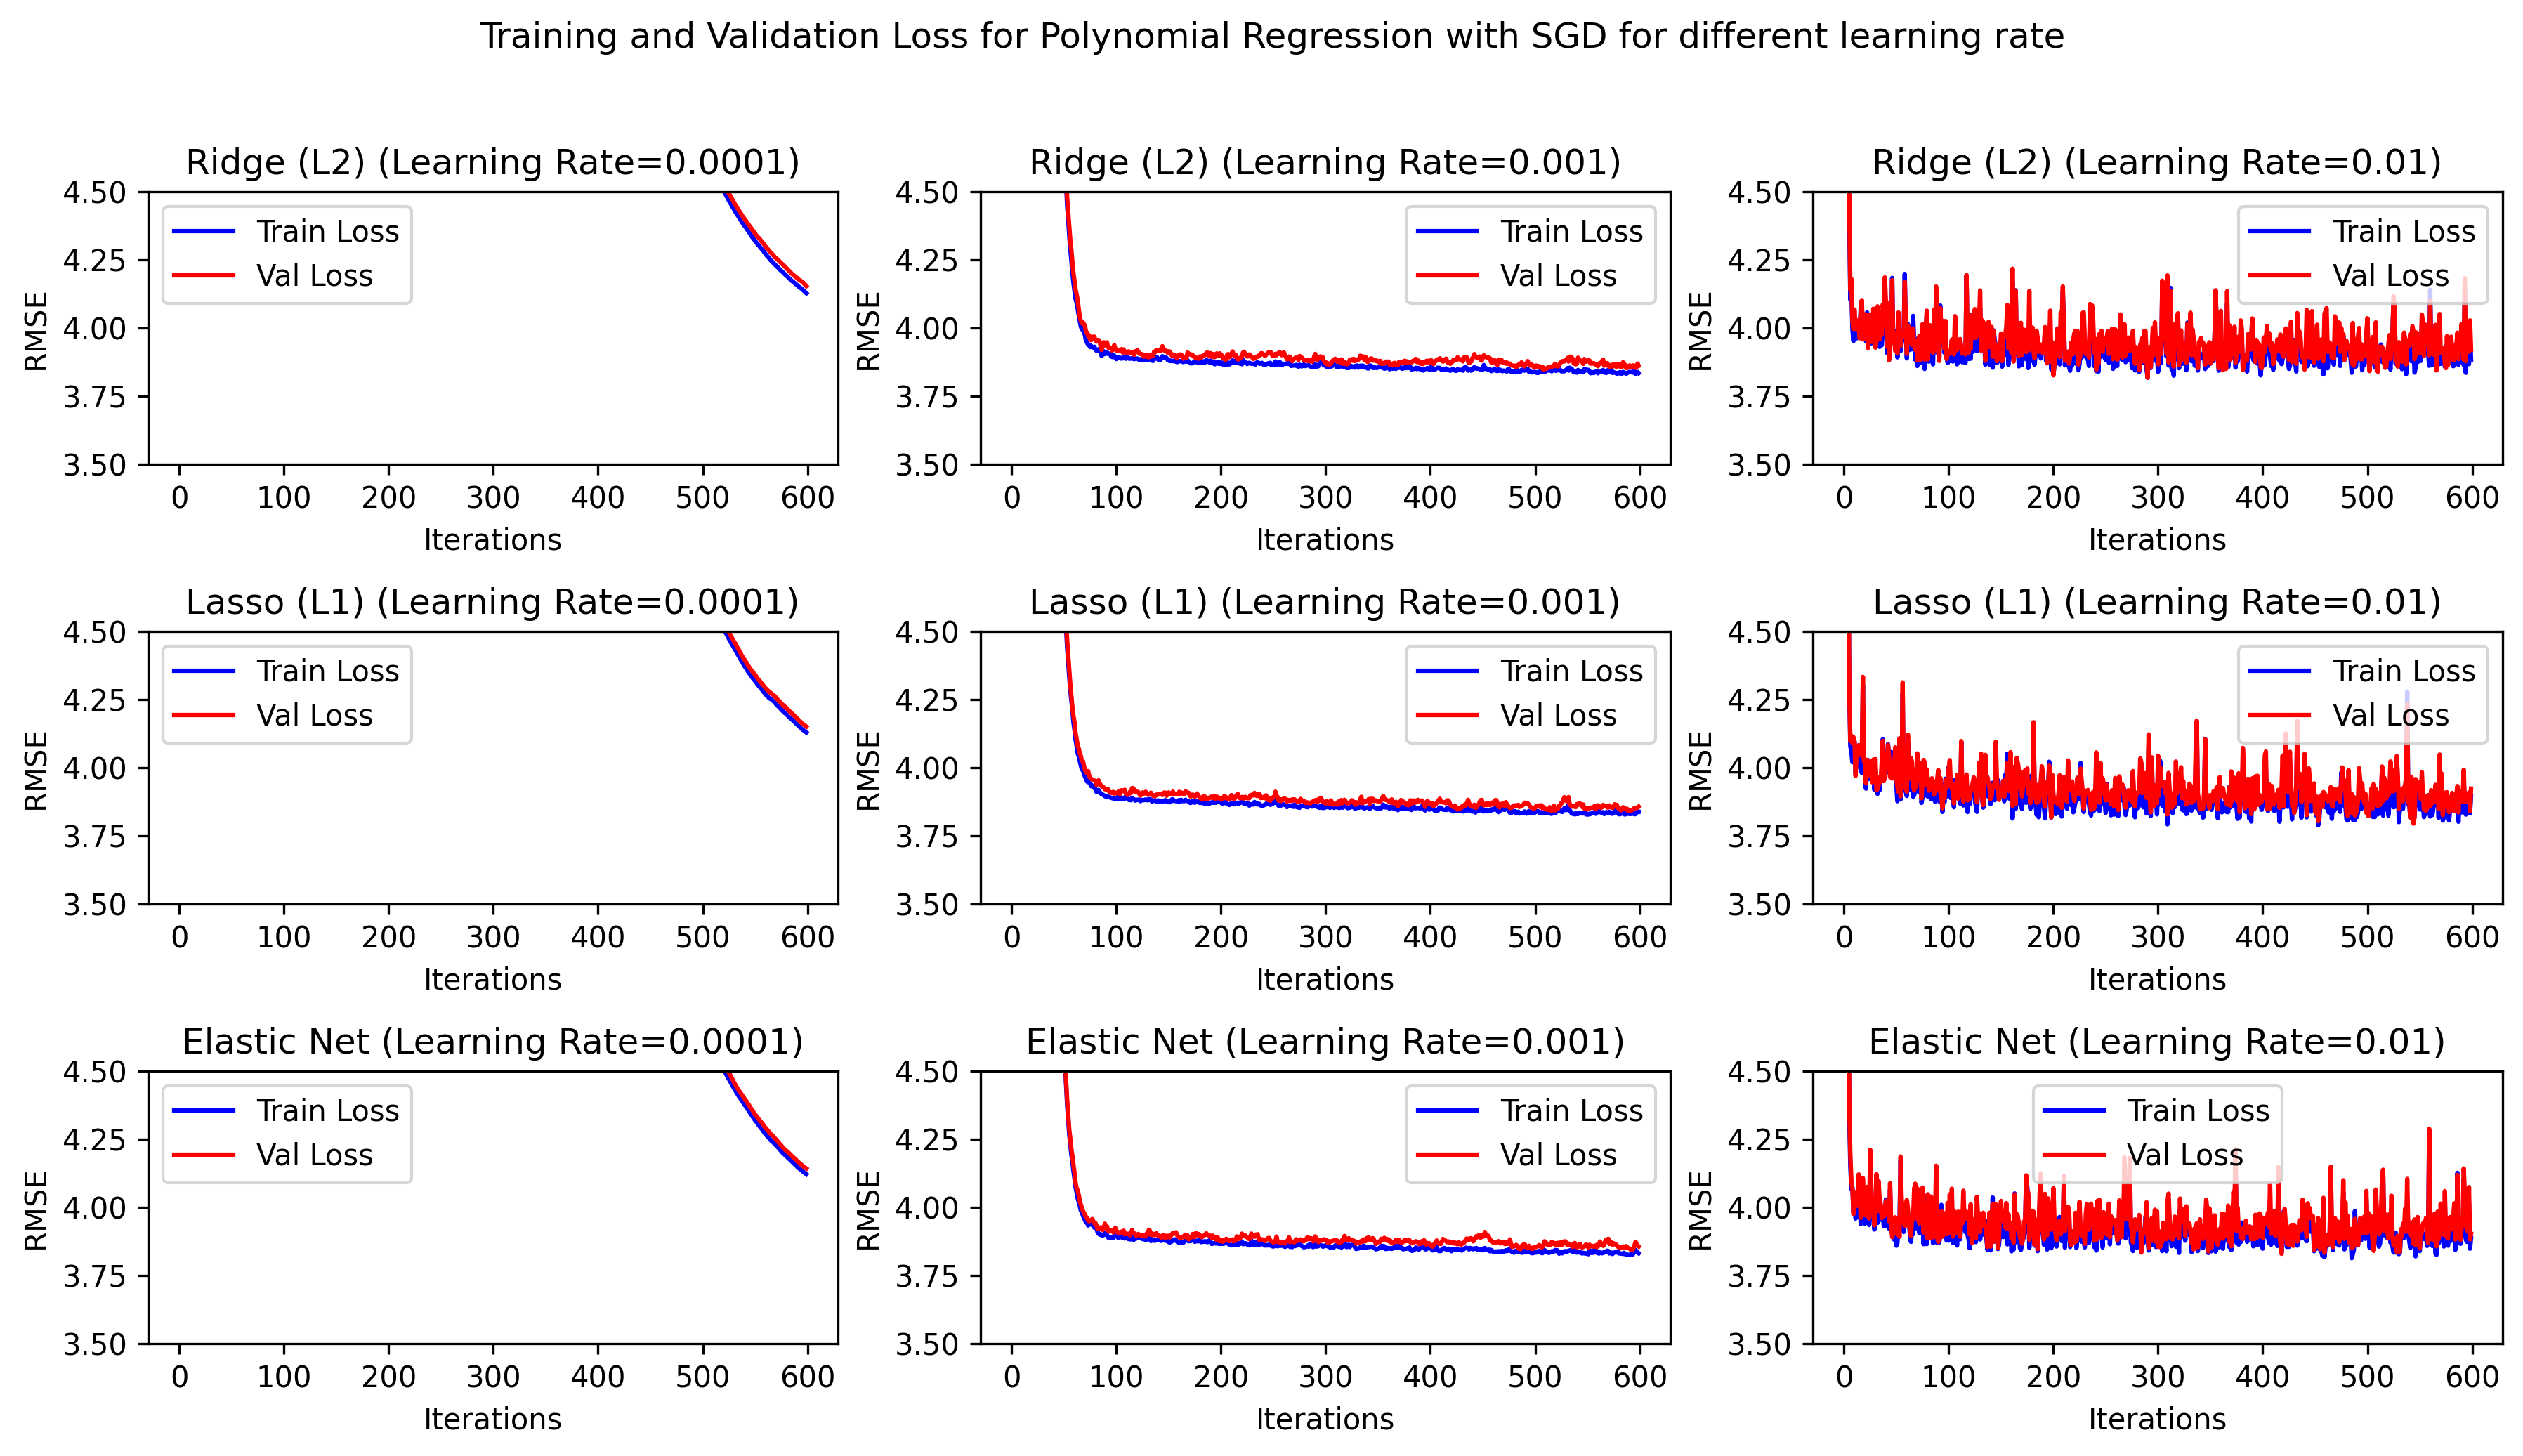

In [28]:
# Define different learning rates and regularization types to test
learning_rates = [0.0001, 0.001, 0.01]
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed settings
degree = 2  # Fixed polynomial degree
alpha = 0.01  # Fixed regularization strength
batch_size = 64  # Fixed batch size
n_iter = 600  # Number of iterations

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression with SGD for different learning rate")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, eta0 in enumerate(learning_rates):
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given learning rate and regularization type
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train using mini-batch SGD
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (Learning Rate={eta0})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(3.5,4.5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### G. Make predictions of the labels on the test data, using the trained model with chosen hyperparameters. Summarize performance using the appropriate evaluation metric. Discuss the results. Include thoughts about what further can be explored to increase performance. [10 points]

**Part1: Prediction on Test Labels**

In [29]:
# Chosen hyperparameters based on previous analysis
degree = 2  # Best degree (simple yet effective)
learning_rate = 0.001  # Best learning rate for stability
batch_size = 64  # Best batch size for balance
alpha = 0.01  # Optimal penalty term
regularization_method = "ridge"  # Ridge (L2) provides best stability

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize polynomial features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Train final model with chosen hyperparameters
sgd_reg = SGDRegressor(
    penalty="l2",  # Ridge (L2) regularization
    alpha=alpha,
    max_iter=1000,  # Sufficient iterations for convergence
    tol=1e-4,
    eta0=learning_rate,
    learning_rate="constant",
    random_state=42
)

# Train using mini-batch SGD
for _ in range(300):  # 300 iterations
    batch_indices = np.random.choice(len(X_train_poly_scaled), batch_size, replace=False)
    X_batch = X_train_poly_scaled[batch_indices]
    y_batch = y_train[batch_indices]
    sgd_reg.partial_fit(X_batch, y_batch)

# Make predictions on test set
y_test_pred = sgd_reg.predict(X_test_poly_scaled)

# Compute RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display RMSE
test_rmse


3.810192611130435

**Performance Summary**

- Test RMSE: 3.7941
- The RMSE value suggests that, on average, the predicted Healthy Life Expectancy at Birth deviates from the actual value by about 3.79 years.
- The predictions (red squares) closely follow the actual values (blue circles), but some discrepancies exist.

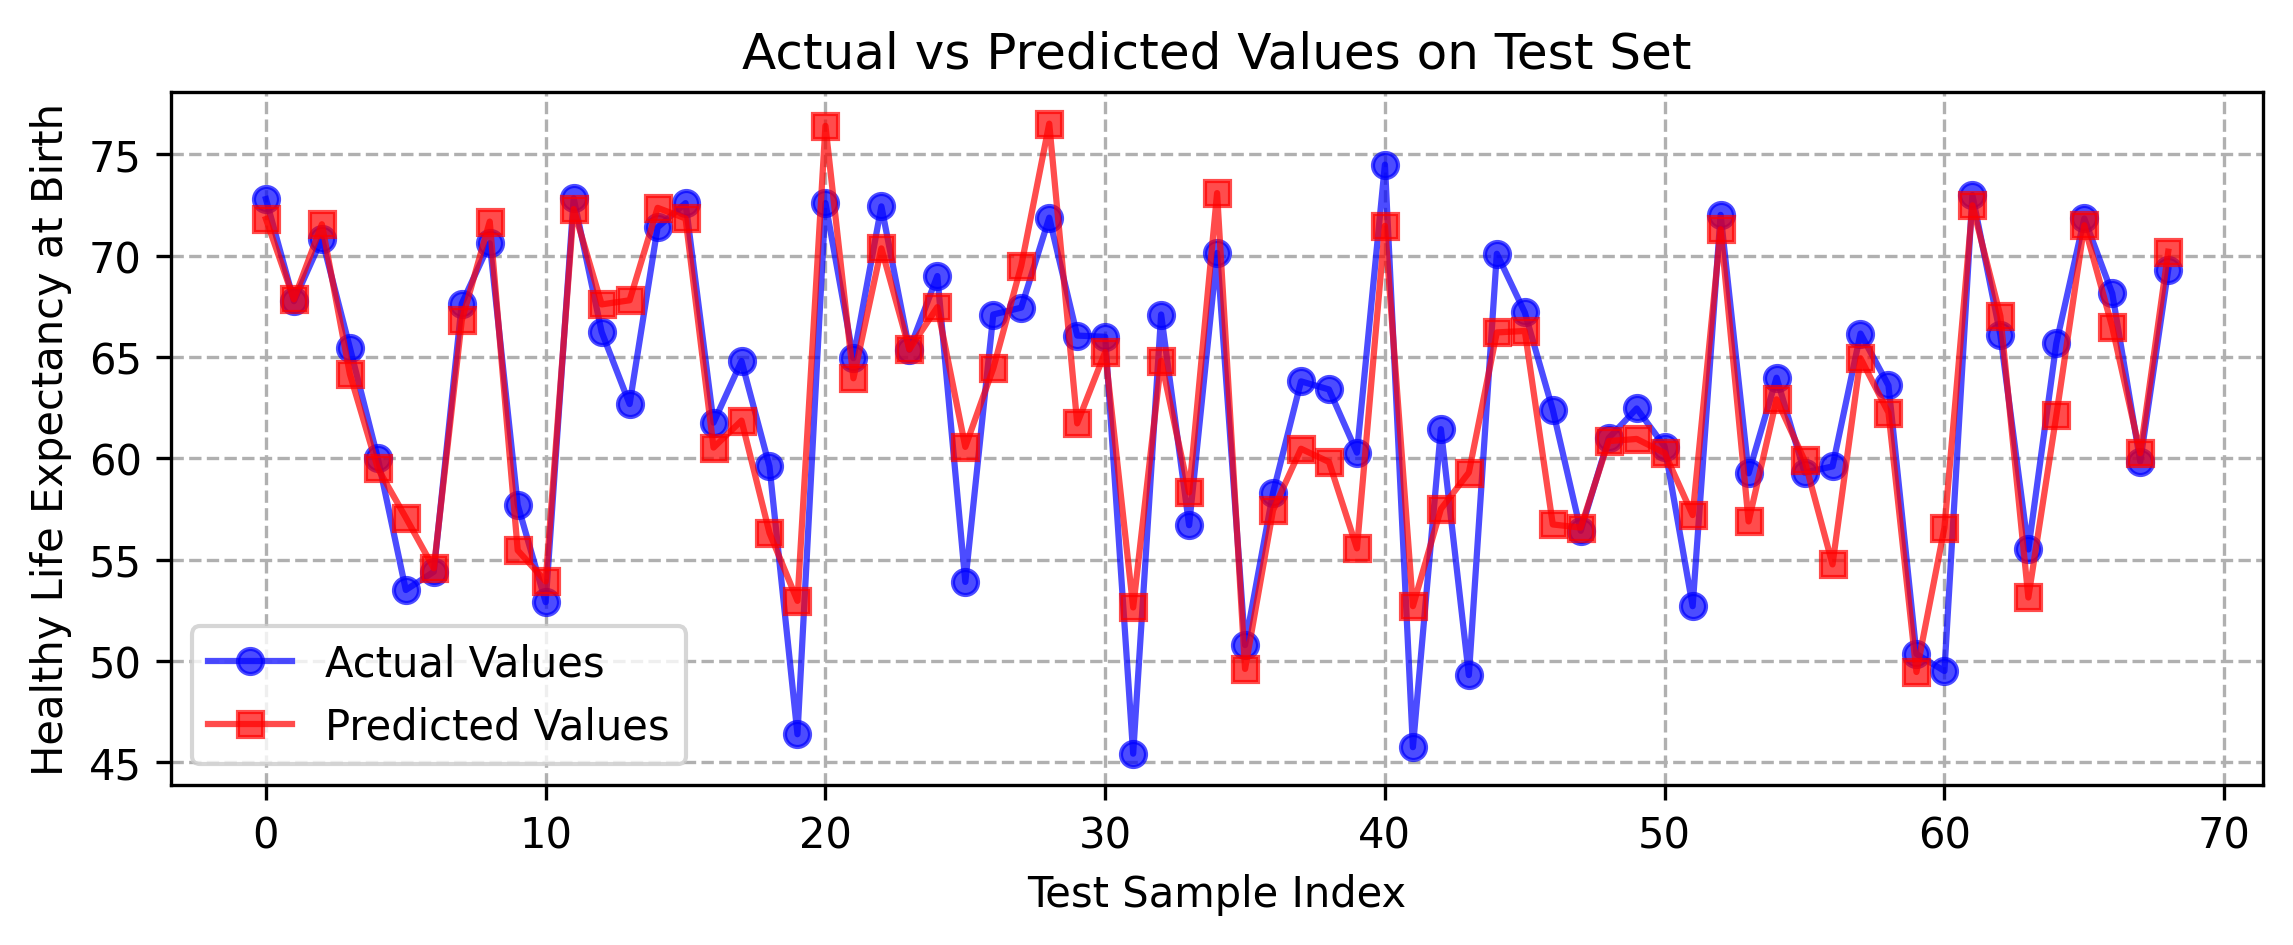

In [30]:
plt.figure(figsize=(9, 3), dpi=300)
# set the plot to display every 5th data point; otherwise, there would be too many points to distinguish.
plt.plot(y_test[::5], label="Actual Values", linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(y_test_pred[::5], label="Predicted Values", linestyle='-', marker='s', color='red', alpha=0.7)
plt.xlabel("Test Sample Index")
plt.ylabel("Healthy Life Expectancy at Birth")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(ls='--')
plt.show()

**Part2: Prediction on Test Labels**

**Discussion of Results**

**1. Accuracy & Generalization**

- The model performs reasonably well given the features used.
- The predicted values capture the general trend of the actual values.
- Some points show larger prediction errors, likely due to: Unaccounted influential factors (e.g., Positive affect) and noise in the dataset affecting generalization.

**2. Regularization Impact**

- Ridge (L2) regularization helped stabilize training and prevent overfitting.
- The chosen hyperparameters (degree = 2, learning rate = 0.001, batch size = 64, alpha = 0.01) provided a good balance between training stability and generalization.

**3.Limitations**

- The model struggles with extreme variations, as seen in some larger gaps between predicted and actual values.
- Feature engineering may be insufficient—important predictors might be missing.

**Future Improvements**

**1. Feature Engineering**

- Include more relevant predictors (e.g., Positive affect).
- Interaction terms: Try degree = 3 polynomial regression to capture complex relationships.

**2. Model Complexity**

- Test more complex models (e.g., Random Forest, Gradient Boosting) to compare performance.
- Use Neural Networks if a large dataset is available.

**3. Hyperparameter Tuning**

- Optimize α (regularization strength) using cross-validation.
- Test batch sizes between 32 and 128 for training efficiency.

**4. Data Augmentation & Cleaning**

- Handle outliers that may be affecting the RMSE.
- Increase dataset size for better generalization.
